### Projet de IFT6512 de François David  -  Matricule: 20171906
### Enseignant: Dr. Fabian Bastin
#### Université de Montréal - Hiver 2020  - Jeudi, le 30 Avril, 2020

Dans ce projet, je compare les 3 méthodes d'algorithmes de convergence discutés dans l'article “Minimizing Finite Sums with Stochastic Average Gradient” écrit par Mark Schmidt, Nicolas Le Roux & Francis Bach. 
Les trois méthodes sont le Stocastic Gradient (SG), le Finite Difference  (FD) ainsi que le Stochastic Average Gradient (SAG). Par la suite, je discute les conditions d'arrêts des algorithmes et je les compare avec une technique de rétrospective approximation. Chacun de ceux-ci est testé sur le MNIST, un exercice de classification d'images. 

Importation des librairies nécessaire.  

In [1]:
import pickle
import numpy as np
import gzip
from random import randint
import timeit
import matplotlib.pyplot as plt

Utilisation de fonction qui charge le DataSet "MNIST", pour la classification d'images de chiffres écrits à la main allants de 0 à 9, chaque image est composé de 784 pixels. J'ai décidé d'utiliser toutes les 50 000 images accessibles de l'ensemble d'apprentissage et toutes les images de l'ensemble de validation disponnibles (5000).
Il y  a donc 50 000 paires d'images et de labels (numéro correspondant à ce que l'image associée représente) pour l'entrainement,  5000 paires pour la validation.

In [7]:
def one_hot(y, n_classes=10):
    return np.eye(n_classes)[y]
def load_mnist():
    data_file = gzip.open("mnist.pkl.gz", "rb")
    train_data, val_data, test_data = pickle.load(data_file, encoding="latin1")
    data_file.close()

    train_inputs = [np.reshape(x, (784, 1)) for x in train_data[0][:20000]]
    train_results = [one_hot(y, 10) for y in train_data[1][:20000]]
    train_data = np.array(train_inputs).reshape(-1, 784), np.array(train_results).reshape(-1, 10)

    val_inputs = [np.reshape(x, (784, 1)) for x in val_data[0][:3000]]
    val_results = [one_hot(y, 10) for y in val_data[1][:3000]]
    val_data = np.array(val_inputs).reshape(-1, 784), np.array(val_results).reshape(-1, 10)

    return train_data, val_data

In [58]:
def one_hot(y, n_classes=10):
    return np.eye(n_classes)[y]
def load_mnist():
    data_file = gzip.open("mnist.pkl.gz", "rb")
    train_data, val_data, test_data = pickle.load(data_file, encoding="latin1")
    data_file.close()

    train_inputs = [np.reshape(x, (784, 1)) for x in train_data[0]]
    train_results = [one_hot(y, 10) for y in train_data[1]]
    train_data = np.array(train_inputs).reshape(-1, 784), np.array(train_results).reshape(-1, 10)

    val_inputs = [np.reshape(x, (784, 1)) for x in val_data[0]]
    val_results = [one_hot(y, 10) for y in val_data[1]]
    val_data = np.array(val_inputs).reshape(-1, 784), np.array(val_results).reshape(-1, 10)

    return train_data, val_data

In [59]:
train, valid = load_mnist()

Définition des fonctions nécessaire pour les algorithms, mais communes au 3 algorithmes.  Certaines petites parties de code ont été adapté du repository git : https://github.com/CW-Huang

In [73]:
def initialize_weights( dims, hidden_dims):
        weights = {}
        # Dictionnaire pour les bias et weights de chaque layers
        all_dims = [dims[0]] + list(hidden_dims) + [dims[1]]
       
        for layer_n in range(1, len(hidden_dims) + 2):
            # Initialize biases to 0.
            weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))
            # glorot initialization.
            dl = np.sqrt(6)/np.sqrt(all_dims[layer_n - 1] + all_dims[layer_n])
            weights[f"W{layer_n}"] = np.random.uniform(-dl, dl, (all_dims[layer_n - 1], all_dims[layer_n]))
        return weights

Fonction de propagation vers l'avant, commune au 3 algorithmes. 

In [10]:
 def forward(x, weights, hidden_dims):
        cache = {"Z0": x}
        for layer in range(1, len(hidden_dims) + 2):
            # Créer  une variable qui va calculer les chaques inputs avec les  weights + le bias. 
            cache[f"A{layer}"] = np.dot(cache[f"Z{layer-1}"], weights[f"W{layer}"]) + weights[f"b{layer}"]
            if layer == len(hidden_dims) + 1:
                # Activation  de l'output pour créer une distribution de probabilité.
                cache[f"Z{layer}"] = softmax(cache[f"A{layer}"])
            else:
                # Activation de cette layer.
                cache[f"Z{layer}"] = relu(cache[f"A{layer}"])
        return cache

Fonction pour transformer les outputs en une distribution discrete de probabilité, commune au 3 algorithmes.

In [11]:
def softmax(x):
        if len(x.shape) == 1:
            newVector = np.exp(x - np.max(x))
            return newVector / np.sum(newVector, axis=0, keepdims=True)
        else:
            newVector = np.exp(x - np.max(x, axis=1, keepdims=True))
            return newVector / np.sum(newVector, axis=1, keepdims=True)

Fonction d'activation, commune au 3 algorithmes. 

In [12]:
def relu(x, grad=False):
        #print("Shape : ", x.shape, "Negative: ", np.count_nonzero(x < 0), "Positive: ", np.count_nonzero(x > 0))
        if grad:
            x[x <= 0.0] = 0.0
            x[x > 0.0] = 1.0
            # print(x)
            #print("Shape : ", x.shape, "Negative: ", np.count_nonzero(x < 0), "Positive: ", np.count_nonzero(x > 0))
            return x
        return np.maximum(x, 0, x)

Fonction de Backpropagatin, commune au 3 algorithmes. 

In [13]:
def backward(weights, cache, labels, hidden_dims):
        output = cache[f"Z{len(hidden_dims) + 1}"]
        grads = {} # Dictionnaire des gradients
        grads[f"dA{len(hidden_dims) + 1}"] = - (labels - output)

        for layer in range(len(hidden_dims) + 1, 0 , -1):
            #m  = grads[f"dA{layer}"].shape[0]
            #print("shape: ", m)
            grads[f"dW{layer}"] = np.dot(grads[f"dA{layer}"].T, cache[f"Z{layer -1}"]).T
            grads[f"db{layer}"] = np.sum(grads[f"dA{layer}"], axis=0, keepdims=True)

            if layer != 1:
                grads[f"dZ{layer - 1}"] = np.dot(weights[f"W{layer}"], grads[f"dA{layer}"].T).T
                grads[f"dA{layer - 1}"] = grads[f"dZ{layer - 1}"] * relu(cache[f"A{layer - 1}"], True)
        return grads

In [14]:
 def lossCalculation(prediction, labels):
        # Pour une marge de manoeuvre.
        epsilon=1e-6 
        prediction[np.where(prediction < epsilon)] = epsilon
        prediction[np.where(prediction > 1 - epsilon)] = 1 - epsilon
        crossEntropy = -sum(np.multiply(labels, np.log(prediction)))

        return np.sum(crossEntropy)

def compute_loss_and_accuracy(X, y, weights, hidden_dims):
        one_y = y
        y = np.argmax(y, axis=1) 
        cache = forward(X, weights, hidden_dims)
        predictions = np.argmax(cache[f"Z{len(hidden_dims) + 1}"], axis=1)
        accuracy = np.mean(y == predictions)
        loss = lossCalculation(cache[f"Z{len(hidden_dims) + 1}"], one_y)
        return loss, accuracy, predictions

In [15]:
def update(grads, weights, hidden_dims, alpha):
        for layer in range(1, len(hidden_dims) + 2):
            weights[f"W{layer}"] = weights[f"W{layer}"] - (alpha * grads[f"dW{layer}"])
            weights[f"b{layer}"] = weights[f"b{layer}"] - (alpha * grads[f"db{layer}"])
        return weights

### Architecture choisie du réseau de neurones

Pour la comparaison des algorithmes, j'ai décidé d'utiliser une architecture qui est composée de deux étages cachés de 64 et 32 neurones. J'ai tenté d'utiliser des étages plus volumineux mais étant donné que pour l'algorithme du SAG nous devons garder en mémoire tous les gradients, la mémoire requise était trop volumineuse pour l'exécution du programme (même en Pyhton native). Le premier étage du réseau est composé de 784 neurones (une par pixel des images du MNIST) et le dernier étage est composé de 10 neurones (pour la classification de 0 à 9). L'initialisation des poids (weights) et biais de l'architecture est faite avec la technique de Glorot. De plus, j'utilise la technique d'activation non-linéaire Relu. 

Même avec cette architecture relativement réduite, le nombre de gradients qu'il faut garder en mémoire par paires de données d'entrainement est de $784 \times  64 + 64 \times 32 + 32 \times 10  + 784 + 64 + 32 = 53424$ ce qui est relativement large considèrent que l'ensemble d'apprentissage est composé  de 50 000 paires.

### Les modifications pour le Stocastic  Gradient Algorithm. 

Le training loop de l'algorithm:

À chaque itération, je génère un index aléatoire entre 0 et la taille de l'ensemble d'apprentissage (50 000) pour pouvoir utiliser qu'une seule des paires de cet ensemble. Le gradient est calculé (à cette itération) avec la paire choisie avec la backpropagation et les weights sont modifiés en fonction de celui-ci. Le cout d'itérations est donc constant et n'est pas en fonction de la taille de l'ensemble , soit n, comme dans l'algorithme du Finite Gradient. Le taux de convergence reste tout de même de $O(1/k)$ par itération (taux de convergence sous-linéaire).

In [137]:
def train_loopSG(n_epochs):
    train_logs = {'train_accuracySG': [], 'validation_accuracySG': [], 'train_lossSG': [], 'validation_lossSG': [], 'time': []}
    X_train, y_train = train
    y_onehot = y_train
    dims = [X_train.shape[1], y_onehot.shape[1]]
    hidden_dims = hidden_dims = (64, 32)
    weights = initialize_weights(dims, hidden_dims)
    batch_size = 1
    alpha = 3.5e-2
    n_batches = 50000
    previousLoss = 2147483647 # Le plus grand integer possible (python)
    for epoch in range(n_epochs):
        if epoch % 1000 == 0 or epoch == 1 or epoch == 501:
            start = timeit.default_timer()
        #  Selection d'un index aléatoire dépendament du nombre de donnée dans le training data.
        indexAleatoire = randint(0, n_batches)
        minibatchX = X_train[batch_size * indexAleatoire:batch_size * (indexAleatoire + 1), :]
        minibatchY = y_onehot[batch_size * indexAleatoire:batch_size * (indexAleatoire + 1), :]
        cache = forward(minibatchX, weights, hidden_dims)
        grads = backward(weights, cache, minibatchY, hidden_dims)
        weights = update(grads, weights, hidden_dims, alpha)

        if epoch % 1000 == 999 or epoch == 0 or epoch == 500:
            X_train, y_train = train
            train_loss, train_accuracy, _ = compute_loss_and_accuracy(X_train, y_train, weights, hidden_dims)
            X_valid, y_valid = valid
            valid_loss, valid_accuracy, _ = compute_loss_and_accuracy(X_valid, y_valid, weights, hidden_dims)
            stop = timeit.default_timer()

            # Imprimer la loss et la precision. Ça l'aide a suivre le progrès
            print(f"Epoch {epoch} : Train Accuracy : {train_accuracy}, \tValid  Accuracy : {valid_accuracy},\t Train Loss : {train_loss}, \tValid Loss :  {valid_loss}, \t Time for 1000 Epochs: {stop - start}")
            
        # Ajuster le taux d'apprentissage si pas de déscente
        if train_loss > previousLoss:
            alpha  = alpha  *  .999999999
        previousLoss = train_loss
        
        train_logs['train_accuracySG'].append(train_accuracy)
        train_logs['validation_accuracySG'].append(valid_accuracy)
        train_logs['train_lossSG'].append(train_loss)
        train_logs['validation_lossSG'].append(valid_loss)
        train_logs['time'].append(stop - start)
        

    return train_logs

In [148]:
trainLogSG = train_loopSG(1000000) 

Epoch 0 : Train Accuracy : 0.08144, 	Valid  Accuracy : 0.0822,	 Train Loss : 122796.04174478057, 	Valid Loss :  24455.056903564644, 	 Time for 1000 Epochs: 0.5547342349891551
Epoch 500 : Train Accuracy : 0.59038, 	Valid  Accuracy : 0.6077,	 Train Loss : 59935.42572618314, 	Valid Loss :  11479.655458592179, 	 Time for 1000 Epochs: 0.7936142139951698
Epoch 999 : Train Accuracy : 0.76578, 	Valid  Accuracy : 0.7864,	 Train Loss : 35844.083468580466, 	Valid Loss :  6631.835288689429, 	 Time for 1000 Epochs: 0.8010772799898405
Epoch 1999 : Train Accuracy : 0.82346, 	Valid  Accuracy : 0.8384,	 Train Loss : 29084.345323703685, 	Valid Loss :  5212.778018040548, 	 Time for 1000 Epochs: 0.8726126739929896
Epoch 2999 : Train Accuracy : 0.80194, 	Valid  Accuracy : 0.8257,	 Train Loss : 32747.45250612174, 	Valid Loss :  5731.721896061396, 	 Time for 1000 Epochs: 0.8308217450103257
Epoch 3999 : Train Accuracy : 0.84374, 	Valid  Accuracy : 0.8597,	 Train Loss : 25563.3048405344, 	Valid Loss :  4583.74

Epoch 45999 : Train Accuracy : 0.93446, 	Valid  Accuracy : 0.9343,	 Train Loss : 13195.585844372888, 	Valid Loss :  2638.8615277646686, 	 Time for 1000 Epochs: 1.0094504170119762
Epoch 46999 : Train Accuracy : 0.9093, 	Valid  Accuracy : 0.9145,	 Train Loss : 17523.186897063595, 	Valid Loss :  3417.409678252878, 	 Time for 1000 Epochs: 0.9606634679948911
Epoch 47999 : Train Accuracy : 0.93062, 	Valid  Accuracy : 0.9356,	 Train Loss : 12187.15682210928, 	Valid Loss :  2293.638464684593, 	 Time for 1000 Epochs: 0.9239213289984036
Epoch 48999 : Train Accuracy : 0.9291, 	Valid  Accuracy : 0.9332,	 Train Loss : 13646.439004895326, 	Valid Loss :  2670.7128992433845, 	 Time for 1000 Epochs: 1.0025465709913988
Epoch 49999 : Train Accuracy : 0.94672, 	Valid  Accuracy : 0.9472,	 Train Loss : 10077.336959259826, 	Valid Loss :  2137.8064744380194, 	 Time for 1000 Epochs: 1.084523182013072
Epoch 50999 : Train Accuracy : 0.9246, 	Valid  Accuracy : 0.9243,	 Train Loss : 13513.448685902085, 	Valid Loss

Epoch 92999 : Train Accuracy : 0.88972, 	Valid  Accuracy : 0.887,	 Train Loss : 29323.631083531196, 	Valid Loss :  6516.756745357527, 	 Time for 1000 Epochs: 0.782509023003513
Epoch 93999 : Train Accuracy : 0.93722, 	Valid  Accuracy : 0.9399,	 Train Loss : 11769.0705986875, 	Valid Loss :  2375.44043025802, 	 Time for 1000 Epochs: 0.8065611989877652
Epoch 94999 : Train Accuracy : 0.93614, 	Valid  Accuracy : 0.9391,	 Train Loss : 14067.244699701512, 	Valid Loss :  2673.474029404563, 	 Time for 1000 Epochs: 0.7961180459824391
Epoch 95999 : Train Accuracy : 0.94578, 	Valid  Accuracy : 0.9448,	 Train Loss : 11278.798420110264, 	Valid Loss :  2390.131414503051, 	 Time for 1000 Epochs: 0.8887272159918211
Epoch 96999 : Train Accuracy : 0.94196, 	Valid  Accuracy : 0.9408,	 Train Loss : 11737.84133645713, 	Valid Loss :  2483.866080824819, 	 Time for 1000 Epochs: 0.8550111359800212
Epoch 97999 : Train Accuracy : 0.93584, 	Valid  Accuracy : 0.9395,	 Train Loss : 12436.587590789903, 	Valid Loss :  

Epoch 138999 : Train Accuracy : 0.94466, 	Valid  Accuracy : 0.9428,	 Train Loss : 11428.258524131857, 	Valid Loss :  2413.810179419185, 	 Time for 1000 Epochs: 0.8997261929907836
Epoch 139999 : Train Accuracy : 0.91388, 	Valid  Accuracy : 0.9169,	 Train Loss : 17533.748010218587, 	Valid Loss :  3381.054753928992, 	 Time for 1000 Epochs: 0.7899998879875056
Epoch 140999 : Train Accuracy : 0.95544, 	Valid  Accuracy : 0.9537,	 Train Loss : 8975.243594859508, 	Valid Loss :  2000.8593177232283, 	 Time for 1000 Epochs: 0.8208613579918165
Epoch 141999 : Train Accuracy : 0.89672, 	Valid  Accuracy : 0.9004,	 Train Loss : 18103.941332615675, 	Valid Loss :  3739.1071033599055, 	 Time for 1000 Epochs: 0.9040363729873206
Epoch 142999 : Train Accuracy : 0.94464, 	Valid  Accuracy : 0.943,	 Train Loss : 10872.482231316426, 	Valid Loss :  2297.6632269054094, 	 Time for 1000 Epochs: 0.8962876099976711
Epoch 143999 : Train Accuracy : 0.94984, 	Valid  Accuracy : 0.9481,	 Train Loss : 10265.580879333933, 	V

Epoch 184999 : Train Accuracy : 0.95068, 	Valid  Accuracy : 0.9465,	 Train Loss : 10347.353085727183, 	Valid Loss :  2413.6025430286036, 	 Time for 1000 Epochs: 0.8416555110015906
Epoch 185999 : Train Accuracy : 0.9445, 	Valid  Accuracy : 0.9415,	 Train Loss : 12436.7085952865, 	Valid Loss :  2835.901084226012, 	 Time for 1000 Epochs: 0.8696729080111254
Epoch 186999 : Train Accuracy : 0.95794, 	Valid  Accuracy : 0.9542,	 Train Loss : 8853.754445512765, 	Valid Loss :  2258.8783681059112, 	 Time for 1000 Epochs: 0.8242343189776875
Epoch 187999 : Train Accuracy : 0.95744, 	Valid  Accuracy : 0.9499,	 Train Loss : 8621.687083524299, 	Valid Loss :  2205.247569760762, 	 Time for 1000 Epochs: 0.8922923380159773
Epoch 188999 : Train Accuracy : 0.94522, 	Valid  Accuracy : 0.941,	 Train Loss : 10772.681953693962, 	Valid Loss :  2555.6404266410254, 	 Time for 1000 Epochs: 0.7993441949947737
Epoch 189999 : Train Accuracy : 0.95262, 	Valid  Accuracy : 0.9474,	 Train Loss : 9948.093041945373, 	Valid 

Epoch 230999 : Train Accuracy : 0.93686, 	Valid  Accuracy : 0.9349,	 Train Loss : 12312.233569836208, 	Valid Loss :  2650.8751987203277, 	 Time for 1000 Epochs: 0.8961734759795945
Epoch 231999 : Train Accuracy : 0.95156, 	Valid  Accuracy : 0.9489,	 Train Loss : 9912.102078747175, 	Valid Loss :  2170.1664642412256, 	 Time for 1000 Epochs: 0.8139872090250719
Epoch 232999 : Train Accuracy : 0.94372, 	Valid  Accuracy : 0.9404,	 Train Loss : 12720.237087407642, 	Valid Loss :  2950.492197229813, 	 Time for 1000 Epochs: 0.9661752789979801
Epoch 233999 : Train Accuracy : 0.93878, 	Valid  Accuracy : 0.9352,	 Train Loss : 13130.715704056987, 	Valid Loss :  2977.883636666263, 	 Time for 1000 Epochs: 0.9148655989847612
Epoch 234999 : Train Accuracy : 0.9463, 	Valid  Accuracy : 0.9439,	 Train Loss : 10445.5423980243, 	Valid Loss :  2423.204654471782, 	 Time for 1000 Epochs: 0.8955072999815457
Epoch 235999 : Train Accuracy : 0.95748, 	Valid  Accuracy : 0.952,	 Train Loss : 8790.626582160989, 	Valid 

Epoch 277999 : Train Accuracy : 0.95684, 	Valid  Accuracy : 0.9487,	 Train Loss : 8649.987652960494, 	Valid Loss :  2163.381861994418, 	 Time for 1000 Epochs: 0.86158919200534
Epoch 278999 : Train Accuracy : 0.95154, 	Valid  Accuracy : 0.9478,	 Train Loss : 10425.594644551547, 	Valid Loss :  2419.9925263511664, 	 Time for 1000 Epochs: 0.8850876490178052
Epoch 279999 : Train Accuracy : 0.95254, 	Valid  Accuracy : 0.9454,	 Train Loss : 9768.874985223123, 	Valid Loss :  2267.217727734443, 	 Time for 1000 Epochs: 0.9481731610139832
Epoch 280999 : Train Accuracy : 0.95184, 	Valid  Accuracy : 0.944,	 Train Loss : 9604.337543918151, 	Valid Loss :  2344.3763431372704, 	 Time for 1000 Epochs: 0.81615482000052
Epoch 281999 : Train Accuracy : 0.95202, 	Valid  Accuracy : 0.9449,	 Train Loss : 10816.43328155297, 	Valid Loss :  2704.849784368597, 	 Time for 1000 Epochs: 0.8395334579981863
Epoch 282999 : Train Accuracy : 0.95974, 	Valid  Accuracy : 0.9527,	 Train Loss : 8364.31252482191, 	Valid Loss 

Epoch 323999 : Train Accuracy : 0.952, 	Valid  Accuracy : 0.9464,	 Train Loss : 10961.363330290005, 	Valid Loss :  2754.747933127178, 	 Time for 1000 Epochs: 1.1274701640068088
Epoch 324999 : Train Accuracy : 0.9508, 	Valid  Accuracy : 0.947,	 Train Loss : 11357.394429922584, 	Valid Loss :  2634.7688817705416, 	 Time for 1000 Epochs: 1.0540679520054255
Epoch 325999 : Train Accuracy : 0.95484, 	Valid  Accuracy : 0.9532,	 Train Loss : 9576.498182825, 	Valid Loss :  2337.611038242786, 	 Time for 1000 Epochs: 1.0290883840061724
Epoch 326999 : Train Accuracy : 0.95764, 	Valid  Accuracy : 0.9507,	 Train Loss : 9350.083710831661, 	Valid Loss :  2422.507962306944, 	 Time for 1000 Epochs: 0.880432286998257
Epoch 327999 : Train Accuracy : 0.9588, 	Valid  Accuracy : 0.9532,	 Train Loss : 8729.910753389162, 	Valid Loss :  2179.212599732251, 	 Time for 1000 Epochs: 0.9636808629729785
Epoch 328999 : Train Accuracy : 0.94836, 	Valid  Accuracy : 0.9412,	 Train Loss : 9921.179645660231, 	Valid Loss :  

Epoch 370999 : Train Accuracy : 0.95656, 	Valid  Accuracy : 0.9482,	 Train Loss : 9499.174228653486, 	Valid Loss :  2442.5649321493247, 	 Time for 1000 Epochs: 1.1875060989987105
Epoch 371999 : Train Accuracy : 0.96058, 	Valid  Accuracy : 0.9541,	 Train Loss : 8299.355229889454, 	Valid Loss :  1980.1000761425432, 	 Time for 1000 Epochs: 1.021348071983084
Epoch 372999 : Train Accuracy : 0.95588, 	Valid  Accuracy : 0.9484,	 Train Loss : 9323.936444809216, 	Valid Loss :  2452.0060360191937, 	 Time for 1000 Epochs: 0.9363126539974473
Epoch 373999 : Train Accuracy : 0.96024, 	Valid  Accuracy : 0.9541,	 Train Loss : 8362.983179706855, 	Valid Loss :  2045.9137828099356, 	 Time for 1000 Epochs: 0.7987117989978287
Epoch 374999 : Train Accuracy : 0.92956, 	Valid  Accuracy : 0.9258,	 Train Loss : 24247.967536835808, 	Valid Loss :  5306.025477554058, 	 Time for 1000 Epochs: 0.8787638600042555
Epoch 375999 : Train Accuracy : 0.94596, 	Valid  Accuracy : 0.937,	 Train Loss : 11793.504947291789, 	Vali

Epoch 417999 : Train Accuracy : 0.94648, 	Valid  Accuracy : 0.9377,	 Train Loss : 10358.7594480948, 	Valid Loss :  2682.2764805099005, 	 Time for 1000 Epochs: 0.8705298890126869
Epoch 418999 : Train Accuracy : 0.94412, 	Valid  Accuracy : 0.941,	 Train Loss : 11435.94608573623, 	Valid Loss :  2744.876212695825, 	 Time for 1000 Epochs: 0.8769318809791002
Epoch 419999 : Train Accuracy : 0.95114, 	Valid  Accuracy : 0.9435,	 Train Loss : 9765.072828386124, 	Valid Loss :  2607.6308249369904, 	 Time for 1000 Epochs: 0.8814767040021252
Epoch 420999 : Train Accuracy : 0.94838, 	Valid  Accuracy : 0.9379,	 Train Loss : 12037.899485465467, 	Valid Loss :  3267.6770553930637, 	 Time for 1000 Epochs: 0.913056924007833
Epoch 421999 : Train Accuracy : 0.9456, 	Valid  Accuracy : 0.9376,	 Train Loss : 11886.866033031582, 	Valid Loss :  2940.966157646464, 	 Time for 1000 Epochs: 0.9358991259941831
Epoch 422999 : Train Accuracy : 0.94962, 	Valid  Accuracy : 0.9418,	 Train Loss : 10430.597485620354, 	Valid 

Epoch 463999 : Train Accuracy : 0.93982, 	Valid  Accuracy : 0.9326,	 Train Loss : 16052.648631938338, 	Valid Loss :  3813.932650466158, 	 Time for 1000 Epochs: 0.838086381991161
Epoch 464999 : Train Accuracy : 0.95328, 	Valid  Accuracy : 0.9448,	 Train Loss : 10544.024738199852, 	Valid Loss :  2999.7772336509065, 	 Time for 1000 Epochs: 0.8423548809951171
Epoch 465999 : Train Accuracy : 0.94818, 	Valid  Accuracy : 0.9429,	 Train Loss : 10306.255587048425, 	Valid Loss :  2712.2191634065134, 	 Time for 1000 Epochs: 0.8397570129891392
Epoch 466999 : Train Accuracy : 0.94866, 	Valid  Accuracy : 0.9398,	 Train Loss : 11847.36523468025, 	Valid Loss :  3037.050061461053, 	 Time for 1000 Epochs: 0.8328860930050723
Epoch 467999 : Train Accuracy : 0.9393, 	Valid  Accuracy : 0.9354,	 Train Loss : 13406.467393931316, 	Valid Loss :  3014.594519640146, 	 Time for 1000 Epochs: 0.8384563639992848
Epoch 468999 : Train Accuracy : 0.94534, 	Valid  Accuracy : 0.9384,	 Train Loss : 10913.698922747619, 	Val

Epoch 509999 : Train Accuracy : 0.94508, 	Valid  Accuracy : 0.9382,	 Train Loss : 10419.364556756744, 	Valid Loss :  2589.884972954655, 	 Time for 1000 Epochs: 0.8067757569951937
Epoch 510999 : Train Accuracy : 0.95464, 	Valid  Accuracy : 0.947,	 Train Loss : 9814.119376320472, 	Valid Loss :  2432.8127528171676, 	 Time for 1000 Epochs: 0.8809628849849105
Epoch 511999 : Train Accuracy : 0.95614, 	Valid  Accuracy : 0.9473,	 Train Loss : 9295.682253437335, 	Valid Loss :  2373.2112412813003, 	 Time for 1000 Epochs: 0.8804934280051384
Epoch 512999 : Train Accuracy : 0.9599, 	Valid  Accuracy : 0.9534,	 Train Loss : 8347.695709806605, 	Valid Loss :  2127.943199977264, 	 Time for 1000 Epochs: 0.8813052640180103
Epoch 513999 : Train Accuracy : 0.96136, 	Valid  Accuracy : 0.9548,	 Train Loss : 8475.670385156916, 	Valid Loss :  2205.187055649014, 	 Time for 1000 Epochs: 0.8748537869832944
Epoch 514999 : Train Accuracy : 0.94668, 	Valid  Accuracy : 0.9431,	 Train Loss : 13554.222843792433, 	Valid 

Epoch 555999 : Train Accuracy : 0.94348, 	Valid  Accuracy : 0.9422,	 Train Loss : 11177.00773437777, 	Valid Loss :  2806.5808618355277, 	 Time for 1000 Epochs: 0.9114923449815251
Epoch 556999 : Train Accuracy : 0.96174, 	Valid  Accuracy : 0.9541,	 Train Loss : 8235.255889983107, 	Valid Loss :  2266.5588668782575, 	 Time for 1000 Epochs: 0.9279505849990528
Epoch 557999 : Train Accuracy : 0.95366, 	Valid  Accuracy : 0.9482,	 Train Loss : 9754.8875696587, 	Valid Loss :  2441.6907731724873, 	 Time for 1000 Epochs: 0.8165212169988081
Epoch 558999 : Train Accuracy : 0.95768, 	Valid  Accuracy : 0.9511,	 Train Loss : 8256.817560820933, 	Valid Loss :  2199.2538350096347, 	 Time for 1000 Epochs: 0.9007713710016105
Epoch 559999 : Train Accuracy : 0.95838, 	Valid  Accuracy : 0.9518,	 Train Loss : 8184.228204612513, 	Valid Loss :  2167.1698463174325, 	 Time for 1000 Epochs: 0.8990522970270831
Epoch 560999 : Train Accuracy : 0.94598, 	Valid  Accuracy : 0.9428,	 Train Loss : 12665.377548638686, 	Vali

Epoch 601999 : Train Accuracy : 0.95696, 	Valid  Accuracy : 0.9499,	 Train Loss : 9624.933247695526, 	Valid Loss :  2517.121633107778, 	 Time for 1000 Epochs: 0.8736707640055101
Epoch 602999 : Train Accuracy : 0.95814, 	Valid  Accuracy : 0.9524,	 Train Loss : 8738.589267378522, 	Valid Loss :  2397.1495495534878, 	 Time for 1000 Epochs: 0.8797145950084087
Epoch 603999 : Train Accuracy : 0.96338, 	Valid  Accuracy : 0.9563,	 Train Loss : 7823.7159258162055, 	Valid Loss :  2316.7040242609514, 	 Time for 1000 Epochs: 0.8909784969873726
Epoch 604999 : Train Accuracy : 0.95336, 	Valid  Accuracy : 0.9457,	 Train Loss : 9357.764782061691, 	Valid Loss :  2635.9664032065675, 	 Time for 1000 Epochs: 0.8031419370090589
Epoch 605999 : Train Accuracy : 0.96422, 	Valid  Accuracy : 0.9576,	 Train Loss : 7986.923319864788, 	Valid Loss :  2363.4061078770515, 	 Time for 1000 Epochs: 0.8549805879883934
Epoch 606999 : Train Accuracy : 0.95844, 	Valid  Accuracy : 0.9522,	 Train Loss : 8289.02575832366, 	Vali

Epoch 647999 : Train Accuracy : 0.95116, 	Valid  Accuracy : 0.9437,	 Train Loss : 11728.078895596653, 	Valid Loss :  2950.9842034566686, 	 Time for 1000 Epochs: 0.8783041489950847
Epoch 648999 : Train Accuracy : 0.9528, 	Valid  Accuracy : 0.9442,	 Train Loss : 12764.39870615974, 	Valid Loss :  3307.9945026069113, 	 Time for 1000 Epochs: 0.8799794469960034
Epoch 649999 : Train Accuracy : 0.95076, 	Valid  Accuracy : 0.944,	 Train Loss : 10853.588258971296, 	Valid Loss :  2956.9504713915835, 	 Time for 1000 Epochs: 0.7958089449966792
Epoch 650999 : Train Accuracy : 0.93966, 	Valid  Accuracy : 0.9308,	 Train Loss : 11004.845829171303, 	Valid Loss :  2940.9367601558743, 	 Time for 1000 Epochs: 0.7929653180181049
Epoch 651999 : Train Accuracy : 0.95286, 	Valid  Accuracy : 0.9455,	 Train Loss : 9698.141598405597, 	Valid Loss :  2742.2256407405534, 	 Time for 1000 Epochs: 0.8854051099915523
Epoch 652999 : Train Accuracy : 0.94946, 	Valid  Accuracy : 0.9424,	 Train Loss : 11129.087894164082, 	V

Epoch 693999 : Train Accuracy : 0.92134, 	Valid  Accuracy : 0.9157,	 Train Loss : 15463.079430812184, 	Valid Loss :  3621.789747937344, 	 Time for 1000 Epochs: 0.972516069014091
Epoch 694999 : Train Accuracy : 0.94474, 	Valid  Accuracy : 0.9361,	 Train Loss : 11717.109299109463, 	Valid Loss :  3020.7775729082396, 	 Time for 1000 Epochs: 0.9203296139894519
Epoch 695999 : Train Accuracy : 0.94322, 	Valid  Accuracy : 0.9339,	 Train Loss : 11135.664009921013, 	Valid Loss :  2813.4703419137995, 	 Time for 1000 Epochs: 0.8040505549870431
Epoch 696999 : Train Accuracy : 0.94316, 	Valid  Accuracy : 0.9377,	 Train Loss : 10974.896236282832, 	Valid Loss :  2715.5396021399547, 	 Time for 1000 Epochs: 0.8753931589890271
Epoch 697999 : Train Accuracy : 0.94852, 	Valid  Accuracy : 0.9407,	 Train Loss : 10142.428718882393, 	Valid Loss :  2631.910380413501, 	 Time for 1000 Epochs: 0.8746150880178902
Epoch 698999 : Train Accuracy : 0.94666, 	Valid  Accuracy : 0.9394,	 Train Loss : 10809.495455379247, 	

Epoch 739999 : Train Accuracy : 0.95696, 	Valid  Accuracy : 0.9458,	 Train Loss : 8796.414651595735, 	Valid Loss :  2497.6227360138714, 	 Time for 1000 Epochs: 0.7313190279819537
Epoch 740999 : Train Accuracy : 0.9561, 	Valid  Accuracy : 0.9463,	 Train Loss : 8646.920068044581, 	Valid Loss :  2667.1627730137593, 	 Time for 1000 Epochs: 0.8194669669901486
Epoch 741999 : Train Accuracy : 0.9309, 	Valid  Accuracy : 0.9223,	 Train Loss : 13803.108491830224, 	Valid Loss :  3594.5610603226846, 	 Time for 1000 Epochs: 0.7340654059953522
Epoch 742999 : Train Accuracy : 0.9476, 	Valid  Accuracy : 0.9376,	 Train Loss : 13251.690688101262, 	Valid Loss :  3591.640910224047, 	 Time for 1000 Epochs: 0.7436310570046771
Epoch 743999 : Train Accuracy : 0.93622, 	Valid  Accuracy : 0.9278,	 Train Loss : 14663.78185802121, 	Valid Loss :  3641.5946099742746, 	 Time for 1000 Epochs: 0.8326155380054843
Epoch 744999 : Train Accuracy : 0.92504, 	Valid  Accuracy : 0.9231,	 Train Loss : 15914.288623847518, 	Vali

Epoch 785999 : Train Accuracy : 0.95128, 	Valid  Accuracy : 0.9432,	 Train Loss : 9781.754443555736, 	Valid Loss :  2743.057742218616, 	 Time for 1000 Epochs: 0.7953827960009221
Epoch 786999 : Train Accuracy : 0.9478, 	Valid  Accuracy : 0.9392,	 Train Loss : 10963.976419656949, 	Valid Loss :  2965.26617749021, 	 Time for 1000 Epochs: 0.8568761839997023
Epoch 787999 : Train Accuracy : 0.9554, 	Valid  Accuracy : 0.9477,	 Train Loss : 10124.59305931284, 	Valid Loss :  2866.3267728493706, 	 Time for 1000 Epochs: 0.8580642990127672
Epoch 788999 : Train Accuracy : 0.95054, 	Valid  Accuracy : 0.9415,	 Train Loss : 13693.931101627004, 	Valid Loss :  3569.6459735979597, 	 Time for 1000 Epochs: 0.7590566900034901
Epoch 789999 : Train Accuracy : 0.941, 	Valid  Accuracy : 0.9342,	 Train Loss : 12215.494215467717, 	Valid Loss :  3214.3169030887466, 	 Time for 1000 Epochs: 0.7621318520104978
Epoch 790999 : Train Accuracy : 0.8905, 	Valid  Accuracy : 0.8794,	 Train Loss : 26394.470888438587, 	Valid L

Epoch 831999 : Train Accuracy : 0.90984, 	Valid  Accuracy : 0.9018,	 Train Loss : 17587.784760256865, 	Valid Loss :  4387.046228438615, 	 Time for 1000 Epochs: 0.7685805870278273
Epoch 832999 : Train Accuracy : 0.9134, 	Valid  Accuracy : 0.9111,	 Train Loss : 20068.087464467342, 	Valid Loss :  4584.781577217251, 	 Time for 1000 Epochs: 0.7734864300000481
Epoch 833999 : Train Accuracy : 0.93012, 	Valid  Accuracy : 0.9223,	 Train Loss : 19859.97593735093, 	Valid Loss :  4692.296383950247, 	 Time for 1000 Epochs: 0.8589680560107809
Epoch 834999 : Train Accuracy : 0.9374, 	Valid  Accuracy : 0.929,	 Train Loss : 17224.397007392552, 	Valid Loss :  4210.4528160359105, 	 Time for 1000 Epochs: 0.7669331269862596
Epoch 835999 : Train Accuracy : 0.89638, 	Valid  Accuracy : 0.894,	 Train Loss : 20677.586292424545, 	Valid Loss :  4582.91588000629, 	 Time for 1000 Epochs: 0.8736853659793269
Epoch 836999 : Train Accuracy : 0.90694, 	Valid  Accuracy : 0.9033,	 Train Loss : 18551.680779508035, 	Valid L

Epoch 877999 : Train Accuracy : 0.95218, 	Valid  Accuracy : 0.9456,	 Train Loss : 9645.280974966963, 	Valid Loss :  2540.481281902843, 	 Time for 1000 Epochs: 0.7552070200035814
Epoch 878999 : Train Accuracy : 0.9512, 	Valid  Accuracy : 0.943,	 Train Loss : 10278.095648062406, 	Valid Loss :  2688.4263468170393, 	 Time for 1000 Epochs: 0.733785478019854
Epoch 879999 : Train Accuracy : 0.94954, 	Valid  Accuracy : 0.9428,	 Train Loss : 10673.551928405304, 	Valid Loss :  2805.0489938812516, 	 Time for 1000 Epochs: 0.7568223740090616
Epoch 880999 : Train Accuracy : 0.95098, 	Valid  Accuracy : 0.9422,	 Train Loss : 9730.684637714578, 	Valid Loss :  2748.0464079685917, 	 Time for 1000 Epochs: 0.7538294309924822
Epoch 881999 : Train Accuracy : 0.94748, 	Valid  Accuracy : 0.9421,	 Train Loss : 10783.012931668341, 	Valid Loss :  2746.970168593053, 	 Time for 1000 Epochs: 0.739478728006361
Epoch 882999 : Train Accuracy : 0.95194, 	Valid  Accuracy : 0.9458,	 Train Loss : 9580.860175129961, 	Valid 

Epoch 923999 : Train Accuracy : 0.94744, 	Valid  Accuracy : 0.9384,	 Train Loss : 11079.583171695054, 	Valid Loss :  3013.3462136269563, 	 Time for 1000 Epochs: 0.8676544149930123
Epoch 924999 : Train Accuracy : 0.94914, 	Valid  Accuracy : 0.9419,	 Train Loss : 10678.959915047966, 	Valid Loss :  2976.268583547382, 	 Time for 1000 Epochs: 0.8727397290058434
Epoch 925999 : Train Accuracy : 0.9513, 	Valid  Accuracy : 0.9426,	 Train Loss : 11992.809975451355, 	Valid Loss :  3189.9252918548714, 	 Time for 1000 Epochs: 0.7805725249927491
Epoch 926999 : Train Accuracy : 0.94516, 	Valid  Accuracy : 0.9381,	 Train Loss : 11502.07579222522, 	Valid Loss :  3227.0153863390606, 	 Time for 1000 Epochs: 0.8665875809965655
Epoch 927999 : Train Accuracy : 0.95196, 	Valid  Accuracy : 0.9427,	 Train Loss : 9573.793496206272, 	Valid Loss :  2770.5758198440226, 	 Time for 1000 Epochs: 0.8325533389870543
Epoch 928999 : Train Accuracy : 0.95346, 	Valid  Accuracy : 0.9431,	 Train Loss : 11561.31839406967, 	Va

Epoch 969999 : Train Accuracy : 0.91562, 	Valid  Accuracy : 0.9071,	 Train Loss : 19681.259447727392, 	Valid Loss :  5044.789106242224, 	 Time for 1000 Epochs: 0.7791599570191465
Epoch 970999 : Train Accuracy : 0.93736, 	Valid  Accuracy : 0.934,	 Train Loss : 13414.425251544637, 	Valid Loss :  3334.043324385448, 	 Time for 1000 Epochs: 0.8729736050008796
Epoch 971999 : Train Accuracy : 0.9073, 	Valid  Accuracy : 0.9024,	 Train Loss : 15694.928701922887, 	Valid Loss :  3734.6713934223367, 	 Time for 1000 Epochs: 0.7760609399992973
Epoch 972999 : Train Accuracy : 0.93838, 	Valid  Accuracy : 0.9355,	 Train Loss : 11894.319719886027, 	Valid Loss :  2800.662539833272, 	 Time for 1000 Epochs: 0.8752044230059255
Epoch 973999 : Train Accuracy : 0.94674, 	Valid  Accuracy : 0.9408,	 Train Loss : 12084.832934490922, 	Valid Loss :  3113.3468706499248, 	 Time for 1000 Epochs: 0.8878025370067917
Epoch 974999 : Train Accuracy : 0.9401, 	Valid  Accuracy : 0.9328,	 Train Loss : 11969.722285482745, 	Val

## Les modification pour le Finite Difference Algorithm. 

À chaque itération, nous passons à travers toutes les paires de données de l'ensemble d'apprentissage pour calculer le gradient idéal moyen. La totalité du gradient est calculée à chaque itération avec la backpropagation et les weights (et biais) sont modifiés en fonction de ce gradient moyen après avoir passé à travers toutes les données de l'ensemble d'entrainement. Le coût d'itérations est donc en fonction de la taille de cet ensemble, $O(n)$. Le taux de convergence est cependant meilleur avec tout de même de $O(p^k)$, pour $0<p<1$, par itération (taux de convergence linéaire).

In [123]:
def train_loopFD(n_epochs):
    train_logs = {'train_accuracyFD': [], 'validation_accuracyFD': [], 'train_lossFD': [], 'validation_lossFD': [], 'time': []}
    X_train, y_train = train
    y_onehot = y_train
    dims = [X_train.shape[1], y_onehot.shape[1]]
    hidden_dims = hidden_dims = (64, 32)
    weights = initialize_weights(dims, hidden_dims)
    batch_size = 1
    alpha = 0.1099
    n_batches = 50000
    previousLoss = 2147483647 # Le plus grand integer possible (python)
    for epoch in range(n_epochs):
        start = timeit.default_timer()
        #  Selection d'un index aléatoire dépendament du nombre de donnée dans le training data.
        gradsS = {}
        for i in range(n_batches):  # La grosseur du training set.
            batchX = X_train[batch_size * i:batch_size * (i + 1), :]
            batchY = y_onehot[batch_size * i:batch_size * (i + 1), :]
            # print(batchX.shape)
            # print(batchY.shape)
            cache = forward(batchX, weights, hidden_dims)
            grads = backward(weights, cache, batchY, hidden_dims)

            # Pour tous les éléments, les additionner pour pouvoir diviser et obtenir la moyenne.
            # Si pas la première itération, additionner les nouveaux grads,
            if i != 0:
                gradsS['dW3'] += grads["dW3"]
                gradsS["dW2"] += grads["dW2"]
                gradsS["dW1"] += grads["dW1"]
                gradsS["db3"] += grads["db3"]
                gradsS["db2"] += grads["db2"]
                gradsS["db1"] += grads["db1"]
            # Si la première itérations, initialiser les gradients avec les gradients respectifs.
            else:
                gradsS['dW3'] = grads["dW3"]
                gradsS["dW2"] = grads["dW2"]
                gradsS["dW1"] = grads["dW1"]
                gradsS["db3"] = grads["db3"]
                gradsS["db2"] = grads["db2"]
                gradsS["db1"] = grads["db1"]
        # Diviser pour obtenir la moyenne de chaque gradients.
        gradsS['dW3'] = gradsS["dW3"] * 1 / n_batches
        gradsS["dW2"] = gradsS["dW2"] * 1 / n_batches
        gradsS["dW1"] = gradsS["dW1"] * 1 / n_batches
        gradsS["db3"] = gradsS["db3"] * 1 / n_batches
        gradsS["db2"] = gradsS["db2"] * 1 / n_batches
        gradsS["db1"] = gradsS["db1"] * 1 / n_batches

        # Updater les weights.
        weights = update(gradsS, weights, hidden_dims, alpha)

        X_train, y_train = train
        train_loss, train_accuracy, _ = compute_loss_and_accuracy(X_train, y_train, weights, hidden_dims)
        X_valid, y_valid = valid
        valid_loss, valid_accuracy, _ = compute_loss_and_accuracy(X_valid, y_valid, weights, hidden_dims)

        stop = timeit.default_timer()

        # Imprimer la loss et la precision. Ça l'aide a suivre le progrès
        print(f"Epoch {epoch} : Train Accuracy : {train_accuracy}, \tValid  Accuracy : {valid_accuracy},\t Train Loss : {train_loss}, \tValid Loss :  {valid_loss} , Time : {stop - start}")
        
        # Ajuster le taux d'apprentissage si pas de déscente
        if train_loss > previousLoss:
            alpha  = alpha  *  .975
        previousLoss = train_loss
        train_logs['train_accuracyFD'].append(train_accuracy)
        train_logs['validation_accuracyFD'].append(valid_accuracy)
        train_logs['train_lossFD'].append(train_loss)
        train_logs['validation_lossFD'].append(valid_loss)
        train_logs['time'].append(stop - start)

    return train_logs

In [124]:
trainLogFD = train_loopFD(80)

Epoch 0 : Train Accuracy : 0.13602, 	Valid  Accuracy : 0.1301,	 Train Loss : 115658.6675690525, 	Valid Loss :  23131.366976003766 , Time : 13.57142488300451
Epoch 1 : Train Accuracy : 0.17352, 	Valid  Accuracy : 0.1708,	 Train Loss : 113569.04532514424, 	Valid Loss :  22716.53910075077 , Time : 15.282209564989898
Epoch 2 : Train Accuracy : 0.20442, 	Valid  Accuracy : 0.2026,	 Train Loss : 111823.409157642, 	Valid Loss :  22367.97846762275 , Time : 13.309911374992225
Epoch 3 : Train Accuracy : 0.23288, 	Valid  Accuracy : 0.2312,	 Train Loss : 110208.84476288529, 	Valid Loss :  22044.886378383824 , Time : 12.375716127018677
Epoch 4 : Train Accuracy : 0.2607, 	Valid  Accuracy : 0.2569,	 Train Loss : 108604.88520980599, 	Valid Loss :  21723.23309548002 , Time : 11.491972374002216
Epoch 5 : Train Accuracy : 0.28388, 	Valid  Accuracy : 0.2837,	 Train Loss : 106936.87651332561, 	Valid Loss :  21388.54565282308 , Time : 13.270202354004141
Epoch 6 : Train Accuracy : 0.3041, 	Valid  Accuracy : 0

Epoch 52 : Train Accuracy : 0.823, 	Valid  Accuracy : 0.8394,	 Train Loss : 34919.00840385108, 	Valid Loss :  6580.280714638193 , Time : 13.613609008025378
Epoch 53 : Train Accuracy : 0.8253, 	Valid  Accuracy : 0.8418,	 Train Loss : 34384.09654958367, 	Valid Loss :  6471.636578517006 , Time : 13.740203066001413
Epoch 54 : Train Accuracy : 0.8275, 	Valid  Accuracy : 0.8442,	 Train Loss : 33868.7047735693, 	Valid Loss :  6367.205828046052 , Time : 18.860835339000914
Epoch 55 : Train Accuracy : 0.83036, 	Valid  Accuracy : 0.8462,	 Train Loss : 33372.307983015606, 	Valid Loss :  6266.736044751913 , Time : 12.27270562297781
Epoch 56 : Train Accuracy : 0.83266, 	Valid  Accuracy : 0.8482,	 Train Loss : 32893.99572013671, 	Valid Loss :  6170.069683349532 , Time : 20.00651339700562
Epoch 57 : Train Accuracy : 0.83498, 	Valid  Accuracy : 0.8505,	 Train Loss : 32433.036700327495, 	Valid Loss :  6077.057567627304 , Time : 33.088970690005226
Epoch 58 : Train Accuracy : 0.83722, 	Valid  Accuracy : 0

## Stochastic Average Gradients 

À chaque itération, (similairement à l'algorithme du Stochastic Gradient) je choisis un indexe aléatoire entre 0 et la taille de l'ensemble d'entrainement (n) pour sélectionner une de ces paires de données pour calculer le gradient respectif à  celle-ci. Le gradient est calculé avec la backpropagation et il  est ajouté à une somme (pour ensuite calculer la moyenne) des autres gradients des itérations antérieures (aussi représentatifs de paires de données aléatoirement choisies). Le nombre d'indexes visité est donc gardé en mémoire sous la variable $k$. 
À  chaque itération, nous calculons le gradient de la paire de données sélectionnées aléatoirement, nous ajoutons le gradient à la somme des gradients et si l'index avait déjà été visité antérieurement, ont soustrait l'ancien  gradient mais nous n'ajustons pas la valeur de k puisque cette paire avait déjà été comptée. S'il n'avait pas été visité antérieurement, nous ajoutons le gradient à la somme et augmentons la valeur de $k= k+ 1$ pour calculer le gradient moyen. Les poids (weights) et  biais sont donc modifiés en fonction de la moyenne de tous les gradients calculés antérieurement. Le cout d'itérations est donc constant et indépendant de la taille de l'ensemble d'entrainement, puisque à chaque itération nous calculons qu'un seul gradient (comme dans l'algorithme du Stochastic Gradient). Le taux de convergence est cependant meilleur avec tout de même de $g^k$, pour $0<g<1$, par itération  (taux de convergence linéaire).

In [143]:
def train_loopSAG(n_epochs):
    train_logs = {'train_accuracyFD': [], 'validation_accuracyFD': [], 'train_lossFD': [], 'validation_lossFD': [],
                  'time': []}
    X_train, y_train = train
    y_onehot = y_train
    dims = [X_train.shape[1], y_onehot.shape[1]]
    hidden_dims = hidden_dims = (64, 32)
    weights = initialize_weights(dims, hidden_dims)
    batch_size = 1
    alpha = 7.9e-3
    n_batches = 50000
    gradsS = {}
    gradsM = {}
    storedGrads = {}
    k = 0
    previousLoss = 2147483647 # Le plus grand integer possible (python)
    for epoch in range(n_epochs):
        if epoch % 1000 == 0 or epoch == 1 or epoch == 501:
            start = timeit.default_timer()
        #  Selection d'un index aléatoire dépendament du nombre de donnée dans le training data.
        indexAleatoire = randint(0, n_batches)

        batchX = X_train[batch_size * indexAleatoire:batch_size * (indexAleatoire + 1), :]
        batchY = y_onehot[batch_size * indexAleatoire:batch_size * (indexAleatoire + 1), :]
        cache = forward(batchX, weights, hidden_dims)
        grads = backward(weights, cache, batchY, hidden_dims)

        #  Si l'index n'a jamais été  tiré, garder en  mémoire les gradients.
        #  Si il a été  tiré, enleve la différence des anciens dans le dictionnaire gradsS.
        if indexAleatoire not in storedGrads:
            storedGrads[indexAleatoire] = {}
            k += 1
            # print("K: ", k)
        else:
            # print("K: Already Picked")
            gradsS['dW3'] -= storedGrads[indexAleatoire]["dW3"]
            gradsS["dW2"] -= storedGrads[indexAleatoire]["dW2"]
            gradsS["dW1"] -= storedGrads[indexAleatoire]["dW1"]
            gradsS["db3"] -= storedGrads[indexAleatoire]["db3"]
            gradsS["db2"] -= storedGrads[indexAleatoire]["db2"]
            gradsS["db1"] -= storedGrads[indexAleatoire]["db1"]

        # Garder en mémoire les anciens grads pour les enlever un fois de nouveau pigé.
        storedGrads[indexAleatoire]["dW3"] = grads["dW3"]
        storedGrads[indexAleatoire]["dW2"] = grads["dW2"]
        storedGrads[indexAleatoire]["dW1"] = grads["dW1"]
        storedGrads[indexAleatoire]["db3"] = grads["db3"]
        storedGrads[indexAleatoire]["db2"] = grads["db2"]
        storedGrads[indexAleatoire]["db1"] = grads["db1"]

        # Ajouter tous les éléments pigé à la somme des gradients,  pour calculer la moyenne après.
        if epoch != 0:
            gradsS['dW3'] += grads["dW3"]
            gradsS["dW2"] += grads["dW2"]
            gradsS["dW1"] += grads["dW1"]
            gradsS["db3"] += grads["db3"]
            gradsS["db2"] += grads["db2"]
            gradsS["db1"] += grads["db1"]
        else:
            gradsS['dW3'] = grads["dW3"]
            gradsS["dW2"] = grads["dW2"]
            gradsS["dW1"] = grads["dW1"]
            gradsS["db3"] = grads["db3"]
            gradsS["db2"] = grads["db2"]
            gradsS["db1"] = grads["db1"]

        # Diviser pour par k pour obtenir la moyenne.
        gradsM['dW3'] = gradsS["dW3"] * 1 / k
        gradsM["dW2"] = gradsS["dW2"] * 1 / k
        gradsM["dW1"] = gradsS["dW1"] * 1 / k
        gradsM["db3"] = gradsS["db3"] * 1 / k
        gradsM["db2"] = gradsS["db2"] * 1 / k
        gradsM["db1"] = gradsS["db1"] * 1 / k

        # Update les weights.
        weights = update(gradsM, weights, hidden_dims, alpha)

        if epoch % 1000 == 999 or epoch == 0 or epoch == 500:
            # Arreter le temps puisque la computation des losses ne differe pas d'un algorithme à l'autre.
            stop = timeit.default_timer()
            X_train, y_train = train
            train_loss, train_accuracy, _ = compute_loss_and_accuracy(X_train, y_train, weights, hidden_dims)
            X_valid, y_valid = valid
            valid_loss, valid_accuracy, _ = compute_loss_and_accuracy(X_valid, y_valid, weights, hidden_dims)

            # Imprimer la loss et la precision. Ça l'aide a suivre le progrès
            print(f"Epoch {epoch} : Train Accuracy : {train_accuracy}, \tValid  Accuracy : {valid_accuracy},\t Train Loss : {train_loss}, \tValid Loss :  {valid_loss} , Time for 1000 epochs : {stop - start}")
            
            # Ajuster le taux d'apprentissage si pas de déscente
            if train_loss > previousLoss:
                alpha  = alpha  *  .9899999
            previousLoss = train_loss
            train_logs['train_accuracyFD'].append(train_accuracy)
            train_logs['validation_accuracyFD'].append(valid_accuracy)
            train_logs['train_lossFD'].append(train_loss)
            train_logs['validation_lossFD'].append(valid_loss)
            train_logs['time'].append(stop - start)

    return train_logs

In [145]:
trainLogSAG = train_loopSAG(800000)

Epoch 0 : Train Accuracy : 0.08946, 	Valid  Accuracy : 0.09,	 Train Loss : 128811.62135089346, 	Valid Loss :  25697.41876322002 , Time for 1000 epochs : 0.0024444779846817255
Epoch 500 : Train Accuracy : 0.54088, 	Valid  Accuracy : 0.548,	 Train Loss : 76174.9911884531, 	Valid Loss :  15059.95844234767 , Time for 1000 epochs : 0.5297584350046236
Epoch 999 : Train Accuracy : 0.6547, 	Valid  Accuracy : 0.6723,	 Train Loss : 47181.21988922776, 	Valid Loss :  8912.99671777594 , Time for 1000 epochs : 0.5584461120015476
Epoch 1999 : Train Accuracy : 0.74086, 	Valid  Accuracy : 0.7681,	 Train Loss : 44226.50128370527, 	Valid Loss :  7893.831077768212 , Time for 1000 epochs : 1.2903144060110208
Epoch 2999 : Train Accuracy : 0.8091, 	Valid  Accuracy : 0.8256,	 Train Loss : 35378.423010021186, 	Valid Loss :  6344.147156639909 , Time for 1000 epochs : 1.3081312029971741
Epoch 3999 : Train Accuracy : 0.79594, 	Valid  Accuracy : 0.8046,	 Train Loss : 33764.62514362122, 	Valid Loss :  6391.85405071

Epoch 45999 : Train Accuracy : 0.9195, 	Valid  Accuracy : 0.9245,	 Train Loss : 14877.124064103547, 	Valid Loss :  2766.728897965541 , Time for 1000 epochs : 1.1595352430013008
Epoch 46999 : Train Accuracy : 0.9193, 	Valid  Accuracy : 0.9249,	 Train Loss : 14865.815891437427, 	Valid Loss :  2759.3401132983945 , Time for 1000 epochs : 1.1605541739845648
Epoch 47999 : Train Accuracy : 0.92108, 	Valid  Accuracy : 0.9262,	 Train Loss : 14522.050164759145, 	Valid Loss :  2691.814850729472 , Time for 1000 epochs : 1.1461176029988565
Epoch 48999 : Train Accuracy : 0.923, 	Valid  Accuracy : 0.9274,	 Train Loss : 14174.689368395862, 	Valid Loss :  2625.736291296159 , Time for 1000 epochs : 1.2093078549951315
Epoch 49999 : Train Accuracy : 0.92362, 	Valid  Accuracy : 0.9286,	 Train Loss : 13855.26277532596, 	Valid Loss :  2577.7034101700174 , Time for 1000 epochs : 1.9880126909993123
Epoch 50999 : Train Accuracy : 0.92376, 	Valid  Accuracy : 0.928,	 Train Loss : 13639.073911889727, 	Valid Loss :

Epoch 92999 : Train Accuracy : 0.92962, 	Valid  Accuracy : 0.9334,	 Train Loss : 11708.44418954411, 	Valid Loss :  2316.259392334541 , Time for 1000 epochs : 1.4995662980072666
Epoch 93999 : Train Accuracy : 0.92818, 	Valid  Accuracy : 0.9313,	 Train Loss : 11962.65724761316, 	Valid Loss :  2360.5455498350775 , Time for 1000 epochs : 1.274018710013479
Epoch 94999 : Train Accuracy : 0.9265, 	Valid  Accuracy : 0.9292,	 Train Loss : 12321.181896589318, 	Valid Loss :  2420.086492010663 , Time for 1000 epochs : 1.4855062440037727
Epoch 95999 : Train Accuracy : 0.92592, 	Valid  Accuracy : 0.9293,	 Train Loss : 12458.679029632332, 	Valid Loss :  2439.8876750582676 , Time for 1000 epochs : 1.2078777849965263
Epoch 96999 : Train Accuracy : 0.92802, 	Valid  Accuracy : 0.9294,	 Train Loss : 12168.128011078838, 	Valid Loss :  2385.5935747544395 , Time for 1000 epochs : 2.047276060009608
Epoch 97999 : Train Accuracy : 0.93094, 	Valid  Accuracy : 0.9318,	 Train Loss : 11666.841701542367, 	Valid Loss

Epoch 138999 : Train Accuracy : 0.93464, 	Valid  Accuracy : 0.9356,	 Train Loss : 10717.185814146269, 	Valid Loss :  2250.4419111793577 , Time for 1000 epochs : 1.2567932470119558
Epoch 139999 : Train Accuracy : 0.93604, 	Valid  Accuracy : 0.9354,	 Train Loss : 10577.036377134034, 	Valid Loss :  2230.67734300099 , Time for 1000 epochs : 1.6598715169820935
Epoch 140999 : Train Accuracy : 0.93738, 	Valid  Accuracy : 0.9362,	 Train Loss : 10415.621448601929, 	Valid Loss :  2203.421586002239 , Time for 1000 epochs : 1.443315729004098
Epoch 141999 : Train Accuracy : 0.93816, 	Valid  Accuracy : 0.9367,	 Train Loss : 10258.790068108256, 	Valid Loss :  2170.76267185042 , Time for 1000 epochs : 1.203809808997903
Epoch 142999 : Train Accuracy : 0.93852, 	Valid  Accuracy : 0.9391,	 Train Loss : 10162.645515120777, 	Valid Loss :  2145.5898539697123 , Time for 1000 epochs : 1.4490944940189365
Epoch 143999 : Train Accuracy : 0.9379, 	Valid  Accuracy : 0.9397,	 Train Loss : 10146.188974305202, 	Valid

Epoch 185999 : Train Accuracy : 0.94482, 	Valid  Accuracy : 0.9451,	 Train Loss : 8991.144781484385, 	Valid Loss :  1899.3666333692317 , Time for 1000 epochs : 1.6771262149850372
Epoch 186999 : Train Accuracy : 0.94524, 	Valid  Accuracy : 0.9451,	 Train Loss : 8914.300366896656, 	Valid Loss :  1874.5084222314858 , Time for 1000 epochs : 1.471729320997838
Epoch 187999 : Train Accuracy : 0.94584, 	Valid  Accuracy : 0.9456,	 Train Loss : 8923.152434837059, 	Valid Loss :  1869.8084829925954 , Time for 1000 epochs : 1.579311374021927
Epoch 188999 : Train Accuracy : 0.9452, 	Valid  Accuracy : 0.9449,	 Train Loss : 9066.093550918364, 	Valid Loss :  1890.6635003753022 , Time for 1000 epochs : 1.462732412997866
Epoch 189999 : Train Accuracy : 0.9437, 	Valid  Accuracy : 0.9441,	 Train Loss : 9278.769740044503, 	Valid Loss :  1925.7833713363452 , Time for 1000 epochs : 1.5498623170133214
Epoch 190999 : Train Accuracy : 0.94214, 	Valid  Accuracy : 0.9429,	 Train Loss : 9485.791024794786, 	Valid Lo

Epoch 231999 : Train Accuracy : 0.94566, 	Valid  Accuracy : 0.9442,	 Train Loss : 8807.712165910507, 	Valid Loss :  1930.3076458798341 , Time for 1000 epochs : 2.5605794889852405
Epoch 232999 : Train Accuracy : 0.94664, 	Valid  Accuracy : 0.9455,	 Train Loss : 8666.91399422484, 	Valid Loss :  1910.6288855889304 , Time for 1000 epochs : 1.7592414420214482
Epoch 233999 : Train Accuracy : 0.94748, 	Valid  Accuracy : 0.9475,	 Train Loss : 8401.710760690956, 	Valid Loss :  1867.1226110442062 , Time for 1000 epochs : 1.631573805003427
Epoch 234999 : Train Accuracy : 0.94998, 	Valid  Accuracy : 0.9489,	 Train Loss : 8139.713335609589, 	Valid Loss :  1824.8826243048593 , Time for 1000 epochs : 1.54157161898911
Epoch 235999 : Train Accuracy : 0.95132, 	Valid  Accuracy : 0.9503,	 Train Loss : 7937.758723381501, 	Valid Loss :  1790.0416823307728 , Time for 1000 epochs : 1.3951874939957634
Epoch 236999 : Train Accuracy : 0.9512, 	Valid  Accuracy : 0.9505,	 Train Loss : 7869.469006457625, 	Valid Lo

Epoch 278999 : Train Accuracy : 0.95384, 	Valid  Accuracy : 0.9479,	 Train Loss : 7435.216991438619, 	Valid Loss :  1782.9315668644495 , Time for 1000 epochs : 1.269394167989958
Epoch 279999 : Train Accuracy : 0.95534, 	Valid  Accuracy : 0.9496,	 Train Loss : 7254.898893467489, 	Valid Loss :  1749.630613371131 , Time for 1000 epochs : 1.0675114399928134
Epoch 280999 : Train Accuracy : 0.95654, 	Valid  Accuracy : 0.9507,	 Train Loss : 7089.022910904975, 	Valid Loss :  1720.6243907973835 , Time for 1000 epochs : 1.0586355310224462
Epoch 281999 : Train Accuracy : 0.95706, 	Valid  Accuracy : 0.9525,	 Train Loss : 6960.541940994916, 	Valid Loss :  1701.4976688481524 , Time for 1000 epochs : 1.201809409976704
Epoch 282999 : Train Accuracy : 0.95798, 	Valid  Accuracy : 0.9525,	 Train Loss : 6882.958147671657, 	Valid Loss :  1693.1746563557513 , Time for 1000 epochs : 1.1101826039957814
Epoch 283999 : Train Accuracy : 0.9579, 	Valid  Accuracy : 0.9527,	 Train Loss : 6860.416058139752, 	Valid L

Epoch 325999 : Train Accuracy : 0.95982, 	Valid  Accuracy : 0.9512,	 Train Loss : 6540.123151661706, 	Valid Loss :  1738.3592891625415 , Time for 1000 epochs : 1.6089662309968844
Epoch 326999 : Train Accuracy : 0.96028, 	Valid  Accuracy : 0.9516,	 Train Loss : 6471.488641209957, 	Valid Loss :  1726.382190725908 , Time for 1000 epochs : 1.8041004099941347
Epoch 327999 : Train Accuracy : 0.96082, 	Valid  Accuracy : 0.9521,	 Train Loss : 6348.169155728247, 	Valid Loss :  1702.498930158291 , Time for 1000 epochs : 1.4149634360219352
Epoch 328999 : Train Accuracy : 0.96156, 	Valid  Accuracy : 0.9534,	 Train Loss : 6209.2397748867, 	Valid Loss :  1674.5133097267358 , Time for 1000 epochs : 1.3958206989918835
Epoch 329999 : Train Accuracy : 0.96206, 	Valid  Accuracy : 0.9543,	 Train Loss : 6119.477095254839, 	Valid Loss :  1655.4625046296044 , Time for 1000 epochs : 1.7831763389986008
Epoch 330999 : Train Accuracy : 0.96172, 	Valid  Accuracy : 0.9545,	 Train Loss : 6093.999703375992, 	Valid L

Epoch 372999 : Train Accuracy : 0.96506, 	Valid  Accuracy : 0.9558,	 Train Loss : 5660.443510722478, 	Valid Loss :  1579.492278610961 , Time for 1000 epochs : 1.6428420380107127
Epoch 373999 : Train Accuracy : 0.96482, 	Valid  Accuracy : 0.9559,	 Train Loss : 5672.806154881141, 	Valid Loss :  1569.1069031406957 , Time for 1000 epochs : 1.5871098760107998
Epoch 374999 : Train Accuracy : 0.96436, 	Valid  Accuracy : 0.9563,	 Train Loss : 5695.7524897233425, 	Valid Loss :  1563.0244350849066 , Time for 1000 epochs : 1.3938324690097943
Epoch 375999 : Train Accuracy : 0.96424, 	Valid  Accuracy : 0.957,	 Train Loss : 5730.687827918973, 	Valid Loss :  1561.2576606269085 , Time for 1000 epochs : 1.4904822560201865
Epoch 376999 : Train Accuracy : 0.96414, 	Valid  Accuracy : 0.957,	 Train Loss : 5750.315988075615, 	Valid Loss :  1560.3666760829656 , Time for 1000 epochs : 1.5709741169994231
Epoch 377999 : Train Accuracy : 0.96412, 	Valid  Accuracy : 0.9566,	 Train Loss : 5757.007306969347, 	Valid

Epoch 419999 : Train Accuracy : 0.96594, 	Valid  Accuracy : 0.9566,	 Train Loss : 5304.336370234045, 	Valid Loss :  1576.8097823039313 , Time for 1000 epochs : 1.3617110770137515
Epoch 420999 : Train Accuracy : 0.96586, 	Valid  Accuracy : 0.9562,	 Train Loss : 5327.604692674115, 	Valid Loss :  1579.2997892220837 , Time for 1000 epochs : 1.0320294879784342
Epoch 421999 : Train Accuracy : 0.96596, 	Valid  Accuracy : 0.9558,	 Train Loss : 5320.31946483123, 	Valid Loss :  1577.2366084475032 , Time for 1000 epochs : 1.1406025789910927
Epoch 422999 : Train Accuracy : 0.96638, 	Valid  Accuracy : 0.9557,	 Train Loss : 5282.606428353957, 	Valid Loss :  1570.1725818504717 , Time for 1000 epochs : 3.1949529830017127
Epoch 423999 : Train Accuracy : 0.96674, 	Valid  Accuracy : 0.9561,	 Train Loss : 5233.423378399919, 	Valid Loss :  1561.6774432942955 , Time for 1000 epochs : 1.1463459490041714
Epoch 424999 : Train Accuracy : 0.9674, 	Valid  Accuracy : 0.9563,	 Train Loss : 5174.964508340166, 	Valid

Epoch 465999 : Train Accuracy : 0.96988, 	Valid  Accuracy : 0.9582,	 Train Loss : 4920.260263144895, 	Valid Loss :  1538.2721965930348 , Time for 1000 epochs : 2.852624327002559
Epoch 466999 : Train Accuracy : 0.96958, 	Valid  Accuracy : 0.958,	 Train Loss : 4941.476189161321, 	Valid Loss :  1543.9753007557367 , Time for 1000 epochs : 1.6378123460162897
Epoch 467999 : Train Accuracy : 0.96978, 	Valid  Accuracy : 0.958,	 Train Loss : 4947.697887641716, 	Valid Loss :  1545.8566384815072 , Time for 1000 epochs : 1.5997875870089047
Epoch 468999 : Train Accuracy : 0.96986, 	Valid  Accuracy : 0.9581,	 Train Loss : 4943.111093027934, 	Valid Loss :  1544.7587795115762 , Time for 1000 epochs : 1.5453008189797401
Epoch 469999 : Train Accuracy : 0.96998, 	Valid  Accuracy : 0.9584,	 Train Loss : 4930.228757362004, 	Valid Loss :  1540.681247502515 , Time for 1000 epochs : 1.5913418749987613
Epoch 470999 : Train Accuracy : 0.96948, 	Valid  Accuracy : 0.9592,	 Train Loss : 4914.938179713094, 	Valid L

Epoch 511999 : Train Accuracy : 0.97142, 	Valid  Accuracy : 0.9581,	 Train Loss : 4686.318335463035, 	Valid Loss :  1547.148203005251 , Time for 1000 epochs : 1.5953124139923602
Epoch 512999 : Train Accuracy : 0.97132, 	Valid  Accuracy : 0.9579,	 Train Loss : 4700.35538430425, 	Valid Loss :  1549.761114286933 , Time for 1000 epochs : 1.3942636179854162
Epoch 513999 : Train Accuracy : 0.97124, 	Valid  Accuracy : 0.9585,	 Train Loss : 4697.152703028282, 	Valid Loss :  1547.4931829996435 , Time for 1000 epochs : 1.4805875000020023
Epoch 514999 : Train Accuracy : 0.9714, 	Valid  Accuracy : 0.9589,	 Train Loss : 4680.052567814429, 	Valid Loss :  1541.4984719284064 , Time for 1000 epochs : 1.494444105977891
Epoch 515999 : Train Accuracy : 0.97156, 	Valid  Accuracy : 0.9586,	 Train Loss : 4649.611017276149, 	Valid Loss :  1533.6175972235376 , Time for 1000 epochs : 1.5415143530117348
Epoch 516999 : Train Accuracy : 0.97186, 	Valid  Accuracy : 0.9583,	 Train Loss : 4611.502821044669, 	Valid Lo

Epoch 557999 : Train Accuracy : 0.9725, 	Valid  Accuracy : 0.9585,	 Train Loss : 4417.028859358916, 	Valid Loss :  1538.1130241288588 , Time for 1000 epochs : 1.0140147999918554
Epoch 558999 : Train Accuracy : 0.97298, 	Valid  Accuracy : 0.9581,	 Train Loss : 4386.714864097685, 	Valid Loss :  1530.6061961733014 , Time for 1000 epochs : 0.9614795929810498
Epoch 559999 : Train Accuracy : 0.973, 	Valid  Accuracy : 0.9588,	 Train Loss : 4351.361082985057, 	Valid Loss :  1520.6433966026352 , Time for 1000 epochs : 0.977228120988002
Epoch 560999 : Train Accuracy : 0.9732, 	Valid  Accuracy : 0.9588,	 Train Loss : 4322.611763327443, 	Valid Loss :  1511.618795056874 , Time for 1000 epochs : 0.9899006920168176
Epoch 561999 : Train Accuracy : 0.97344, 	Valid  Accuracy : 0.9597,	 Train Loss : 4307.2540477373705, 	Valid Loss :  1505.112457527662 , Time for 1000 epochs : 1.2154536249872763
Epoch 562999 : Train Accuracy : 0.97298, 	Valid  Accuracy : 0.9593,	 Train Loss : 4305.542430024153, 	Valid Los

Epoch 603999 : Train Accuracy : 0.97366, 	Valid  Accuracy : 0.9581,	 Train Loss : 4226.978810656567, 	Valid Loss :  1542.2553398994592 , Time for 1000 epochs : 1.3299221390043385
Epoch 604999 : Train Accuracy : 0.97388, 	Valid  Accuracy : 0.9583,	 Train Loss : 4214.482132662933, 	Valid Loss :  1543.2579995581666 , Time for 1000 epochs : 1.5491531800071243
Epoch 605999 : Train Accuracy : 0.97404, 	Valid  Accuracy : 0.9586,	 Train Loss : 4192.47089864531, 	Valid Loss :  1541.574703632583 , Time for 1000 epochs : 1.2048324680072255
Epoch 606999 : Train Accuracy : 0.97414, 	Valid  Accuracy : 0.959,	 Train Loss : 4167.580817265779, 	Valid Loss :  1538.3147816010921 , Time for 1000 epochs : 1.063328137010103
Epoch 607999 : Train Accuracy : 0.97418, 	Valid  Accuracy : 0.9593,	 Train Loss : 4145.591499522977, 	Valid Loss :  1535.076141276299 , Time for 1000 epochs : 1.4903250570059754
Epoch 608999 : Train Accuracy : 0.97444, 	Valid  Accuracy : 0.9593,	 Train Loss : 4130.84841623001, 	Valid Los

Epoch 649999 : Train Accuracy : 0.97568, 	Valid  Accuracy : 0.9583,	 Train Loss : 3967.457783213589, 	Valid Loss :  1536.9484731841044 , Time for 1000 epochs : 2.686114759009797
Epoch 650999 : Train Accuracy : 0.97564, 	Valid  Accuracy : 0.9584,	 Train Loss : 3981.292468086816, 	Valid Loss :  1539.912153487513 , Time for 1000 epochs : 1.5014505180006381
Epoch 651999 : Train Accuracy : 0.97542, 	Valid  Accuracy : 0.9585,	 Train Loss : 4001.1308325381815, 	Valid Loss :  1544.3334069827947 , Time for 1000 epochs : 1.5150403449952137
Epoch 652999 : Train Accuracy : 0.97532, 	Valid  Accuracy : 0.9586,	 Train Loss : 4022.6132078484025, 	Valid Loss :  1549.1163525904035 , Time for 1000 epochs : 1.0668389709899202
Epoch 653999 : Train Accuracy : 0.97498, 	Valid  Accuracy : 0.9581,	 Train Loss : 4036.5761919554807, 	Valid Loss :  1552.6745752814163 , Time for 1000 epochs : 1.0696045809891075
Epoch 654999 : Train Accuracy : 0.97504, 	Valid  Accuracy : 0.9581,	 Train Loss : 4039.176483688899, 	Va

Epoch 695999 : Train Accuracy : 0.97568, 	Valid  Accuracy : 0.9577,	 Train Loss : 3895.1714326353936, 	Valid Loss :  1545.2168340117198 , Time for 1000 epochs : 1.2638434679829516
Epoch 696999 : Train Accuracy : 0.97578, 	Valid  Accuracy : 0.9576,	 Train Loss : 3893.1569184179098, 	Valid Loss :  1546.0423258800859 , Time for 1000 epochs : 1.397146731003886
Epoch 697999 : Train Accuracy : 0.976, 	Valid  Accuracy : 0.958,	 Train Loss : 3888.0939953522893, 	Valid Loss :  1546.391554433899 , Time for 1000 epochs : 2.1972720839839894
Epoch 698999 : Train Accuracy : 0.97602, 	Valid  Accuracy : 0.958,	 Train Loss : 3881.734697593035, 	Valid Loss :  1546.6236051442747 , Time for 1000 epochs : 1.7632037200091872
Epoch 699999 : Train Accuracy : 0.9762, 	Valid  Accuracy : 0.9583,	 Train Loss : 3876.396714509795, 	Valid Loss :  1546.9387566349199 , Time for 1000 epochs : 2.686558142013382
Epoch 700999 : Train Accuracy : 0.97614, 	Valid  Accuracy : 0.9585,	 Train Loss : 3873.1497972256993, 	Valid L

Epoch 741999 : Train Accuracy : 0.97702, 	Valid  Accuracy : 0.957,	 Train Loss : 3806.0614381849136, 	Valid Loss :  1578.1988502975987 , Time for 1000 epochs : 1.241922954999609
Epoch 742999 : Train Accuracy : 0.9769, 	Valid  Accuracy : 0.9569,	 Train Loss : 3805.5366687479386, 	Valid Loss :  1579.5710110602054 , Time for 1000 epochs : 1.1818526329880115
Epoch 743999 : Train Accuracy : 0.97698, 	Valid  Accuracy : 0.957,	 Train Loss : 3804.8346159756984, 	Valid Loss :  1580.4872812817043 , Time for 1000 epochs : 1.1483458649890963
Epoch 744999 : Train Accuracy : 0.97714, 	Valid  Accuracy : 0.957,	 Train Loss : 3803.1282735484156, 	Valid Loss :  1580.7300421640848 , Time for 1000 epochs : 1.65536198602058
Epoch 745999 : Train Accuracy : 0.97712, 	Valid  Accuracy : 0.9573,	 Train Loss : 3800.4582792259002, 	Valid Loss :  1580.4737802364384 , Time for 1000 epochs : 1.2157524309877772
Epoch 746999 : Train Accuracy : 0.97718, 	Valid  Accuracy : 0.9575,	 Train Loss : 3796.5461684243223, 	Vali

Epoch 787999 : Train Accuracy : 0.97792, 	Valid  Accuracy : 0.9575,	 Train Loss : 3694.6761432700773, 	Valid Loss :  1570.9964858978244 , Time for 1000 epochs : 1.3595549979945645
Epoch 788999 : Train Accuracy : 0.97798, 	Valid  Accuracy : 0.9575,	 Train Loss : 3694.141871019865, 	Valid Loss :  1572.3562197988542 , Time for 1000 epochs : 1.566001730010612
Epoch 789999 : Train Accuracy : 0.9778, 	Valid  Accuracy : 0.9578,	 Train Loss : 3696.117177501909, 	Valid Loss :  1574.4760865798955 , Time for 1000 epochs : 1.2819081720081158
Epoch 790999 : Train Accuracy : 0.9778, 	Valid  Accuracy : 0.9577,	 Train Loss : 3700.4855403033353, 	Valid Loss :  1577.0456125515027 , Time for 1000 epochs : 1.3911307170055807
Epoch 791999 : Train Accuracy : 0.97772, 	Valid  Accuracy : 0.958,	 Train Loss : 3705.815125005499, 	Valid Loss :  1579.508770354867 , Time for 1000 epochs : 1.2668005919840652
Epoch 792999 : Train Accuracy : 0.97762, 	Valid  Accuracy : 0.9579,	 Train Loss : 3710.434827272686, 	Valid 

#### Fonction pour calculer le temps en fonction de chaque epochs. 

In [25]:
def calculatesTimes(X):
    newArr = []
    newArr.append(X[0])
    for i in range(1, len(X)):
        newArr.append(X[i] + newArr[i-1])
    return newArr

# Graphiques, comparaison et discussion.

/Users/francoisdavid/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


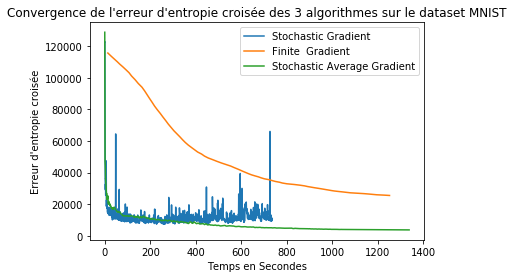

In [149]:
plt.plot(calculatesTimes(trainLogSG["time"]), trainLogSG["train_lossSG"] )
plt.plot(calculatesTimes(trainLogFD["time"]), trainLogFD["train_lossFD"] )
plt.plot(calculatesTimes(trainLogSAG["time"][:800]), trainLogSAG["train_lossFD"][:800] )


plt.xlabel('Temps en Secondes')
plt.ylabel('Erreur d\'entropie croisée')

plt.legend(["Stochastic Gradient", "Finite  Gradient" , "Stochastic Average Gradient"])
plt.title("Convergence de l'erreur d\'entropie croisée des 3 algorithmes sur le dataset MNIST")
plt.show()

## Analyse

Comparativement, nous pouvons voir que l'algorithme du SAG converge de façon très rapide vers l'optimum. Au départ, puisque les index visités sont minimes, l'algorithme du SAG diminue très rapidement l'erreur tel l'algorithme du Stochastic Gradient. Par la suite, plus les itérations se multiplient, plus la moyenne des gradients visités prend en considération plus de paires du de l'ensemble d'entrainement et, par ce fait même, des tendances de l'algorithme du Finite Gradient.

In [350]:
print("SG Temps pour 1000 itérations: ", np.array(trainLogSG["time"]).mean() * 1000 , " secondes")
print("FD Temps pour 1 itération: ", np.array(trainLogFD["time"]).mean(), " secondes")
print("SAG Temps pour 1000 itérations: ", np.array(trainLogSAG["time"][:800]).mean(), " secondes")

SG Temps pour 1000 itérations:  0.7366669293014857  secondes
FD Temps pour 1 itération:  15.659318439675554  secondes
SAG Temps pour 1000 itérations:  1.6737234646915748  secondes


L'algorithme du Finite Gradient est celui qui prend le plus de temps puisqu'il itère sur toutes les données de  l'ensemble d'entrainement, pour un total de 80 "effectives passes" à travers les données ($80 \times 50 000$ calculations de gradients pour 80 modifications de paramètres du réseau de neurones). Chacune de ces modifications prenait environ 15.66 secondes à être calculée. 
Comparativement à l'algorithme du Stochastic Gradient, le SAG prend un peu plus de temps (pour le même nombre d'évaluation de fonctions/itérations) principalement puisque nous devons ajuster le dictionnaire de mémoire des gradients ainsi que le déplacement avec la moyenne des index recherchés. Pour 1000 itérations (modifications des paramètres) l'algorithme SG prend environ 0.73 secondes / 1000 itérations  alors que le SAG prend environ 1.6737 secondes  / 1000 itérations.

Il est facile de voir que,  au  départ, l'algorithme du Stochastic Gradient converge rapidement vers l'optimum. Cependant, il se met à osciller vers  la valeur d'environ 18000 de l'erreur d'entropy-croisée puisque les modifications faites à l'algorithme ne reflètent pas toutes les fonctions désirées (paires de données) et ne représente pas une direction de descente générale vers l'optimum. De plus, nous pouvons constater que le SAG obtient les mêmes tendances que le SG (converge rapide au départ) mais n'oscille pas beaucoup dans la convergence puisque les fonctions prises en compte dans le gradient de déplacement sont plus nombreuses et donc plus générales, ce qui permet d'avoir une meilleure estimation de la descente optimale.  

Après les premières itérations de l'algorithme, le SAG devient similaire au Finite Gradient tout en gardant un coût d'itération de O(1) comparativement à O(n) pour le Finite Gradient. Au final, pour un considérable laps de temps, nous  pouvons donc voir que le SAG se rapproche plus rapidement de l'optimum que le FG et devrait être utilisé si nous n'avons pas assez de ressources/temps pour évaluer les finite gradient jusqu'à point minimum (optimum) de la fonction g(x). 

Il est important de noter que dans l'algorithme du Stochastic Gradient ainsi que le Stochastic Average Gradient, je n'ai pas utilisé de Minibatch pour pouvoir observer les tendances des algorithmes standards (sans prendre avantage de la computation en parallèle des architectures modernes).  Cependant, il pourrait être intéressant de comparer les algorithmes avec les minibatchs puisque de ce fait, les gradients calculés à chaque itération seraient une moyennes d'un nombre arbitraire de fonctions/paires de données et seraient donc plus représentatifs du gradient optimal. Dans cette même optique, le calcul des gradients dans l'algorithme du Finite Difference est fait un à la fois pour ne pas qu'un algorithme soit avantagé par la computation en parallèle.

#### Évaluation similaire sur le set de validation.

/Users/francoisdavid/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


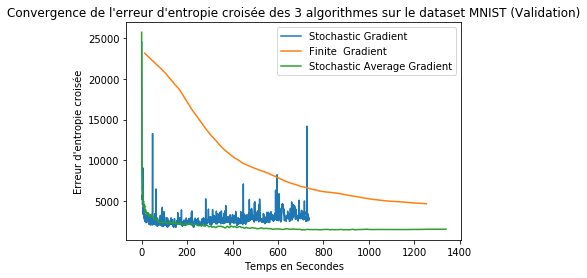

In [351]:
plt.plot(calculatesTimes(trainLogSG["time"]), trainLogSG["validation_lossSG"] )
plt.plot(calculatesTimes(trainLogFD["time"]), trainLogFD["validation_lossFD"] )
plt.plot(calculatesTimes(trainLogSAG["time"][:800]), trainLogSAG["validation_lossFD"][:800] )

plt.xlabel('Temps en Secondes')
plt.ylabel('Erreur d\'entropie croisée')

plt.legend(["Stochastic Gradient", "Finite  Gradient" , "Stochastic Average Gradient"])
plt.title("Convergence de l'erreur d\'entropie croisée des 3 algorithmes sur le dataset MNIST (Validation)")
plt.show()

Nous pouvons voir que les mêmes tendances sont observées sur le set de validation comparativement au set d'entrainement. Ce qui signifie que les tendances sont représentatives des données similaires au MNIST et le modèle peut performer de manière similaire sur de nouvelles images du même type. 

### Discusion  sur les conditions d'arrêt des algorithmes. 

Une des questions importantes dans l'entrainement des algorithmes d'entrainement de Deep Learning est les conditions d'arrêts, soit quand devons-nous arrêter d'entrainer notre réseau de neurones. Pour l'algorithme du Stochastic Average Gradient ainsi que celui du Finite Gradient, il devrait toujours se diriger de manière relativement constante vers l'objectif X*. Dans ce cas, il est avantageux d'exécuter l'algorithme pour le plus de temps possible jusqu'à ce qu'il ait atteint le seuil de précision espéré. Ces algorithmes se dirigent vers l'optimum de manière linéaire avec un taux de convergence de $g^k$ pour $0<g<1$. Cependant, le Stochastic Average Gradient prend en considération que le gradient de chaque fonction sélectionnée est relativement proche du gradient des prochaines itérations. Dans quelques situations, il se peut que ce ne soit pas le cas et que le modèle ne s'améliore pas à chaque itération. Dans ce cas, il serait préférable d'avoir une condition d'arrêt si le modèle n'améliore pas la situation actuelle (comme le "Early-Stopping" discuté dans le dernier paragraphe de cette sous-section. 

Dans le cas de l'algorithme du Stochastic Gradient, il converge vers l'optimum de manière sous-linéaire avec un  taux de convergence de $1/k$. Après un grand nombre d'itérations k, le progrès marginal vers la solution diminue grandement et puisque chaque itération de cet algorithme ne prend en considération qu'une paire de données de l'ensemble d'entrainement, l'algorithme peut osciller puisque le gradient calculé n'était pas le gradient optimal.  Donc un point à une certaine itération antérieure peut avoir obtenu une meilleure optimisation de  l'objectif.

Une technique utile pour le Stochastic Gradient est une version de ce qui est appelé l' "early-stopping" où nous calculons à chaque itération le résultat de la fonction objectif, gardons en mémoire les paramètres de l'itération à laquelle la fonction objective était la plus optimale. Lorsque ce résultat n'a pas été améliorer (diminuer dans ce cas-ci) pour un certain nombre d'itérations, nous arrêtons l'algorithme et utilisons les paramètres qui ont été sauvegardés à l'itération durant laquelle la solution était la plus optimale. 

### Approche avec une technique de "Retrospective Approximation" adaptée

Dans cet algorithme, j'utilise les concepts de Retrospective Approximation pour tenter d'obtenir un comparatif avec les trois algorithmes étudiés plus haut.  Je commence l'algorithme avec un ensemble de 100 fonctions (paires de données) et je modifie l'architecture avec le finite gradient sur cet ensemble (rapide et précis la taille de cet ensemble n'est pas grande) pour obtenir un niveau d'erreur de précision de classification de $ 80\% \times \left(\frac{99}{100}\right)^k $, ou k est l'itération actuelle. Cette séquence tend vers 0 alors que les itérations s'accumulent, nous sommes donc de plus en plus exigeants par rapport à la performance de l'algorithme.

À chaque itération, la taille des échantillons correspond à $ 100 + (100)k $, ou k est l'itération actuelle. Donc la taille de l'échantillon que nous prenons en compte augmente de 100 nouvelles fonctions/paires de données à chaque itération. La séquence des Ws peut être décrite par à l'iteration k par :  $1/2$ à l'itération actuelle et $1/{2^{k+1-i}}$ pour tous les index des itérations antérieures i. À chaque itération, je m'assure de prendre les données d'entrainement qui n'ont pas été choisies à l'itération précédente en gardant un index modulo de la taille de cet ensemble. Dans cet exemple simpliste, l'échantillon est augmenté linéairement et inclus continuellement de nouvelles fonctions f(x).

Après plusieurs essais-erreurs, j'ai également constaté qu'il était peut-être plus adéquat de ne plus diminuer l'erreur désirée lorsqu'elle devenait inférieure à 4% puisque les itérations prenaient une large durée de temps pour converger sans trop faire de progrès sur l'ensemble des données et je ne voulais pas que l'algorithme "overtrain" sur les données de l'échantillon. De plus, dans les 3 algorithmes plus haut, l'erreur de précision de classification devient rarement en dessous de 3-4 % pour l'ensemble des 50 000 paires de données. 

In [375]:
def train_loopRetroApprox(iterations):
    train_logs = {'train_accuracyFD': [], 'validation_accuracyFD': [], 'train_lossFD': [], 'validation_lossFD': [], 'time': []}
    X_trainAll, y_trainAll = train
    y_onehot = y_trainAll
    dims = [X_trainAll.shape[1], y_onehot.shape[1]]
    hidden_dims = hidden_dims = (64, 32)
    weights = initialize_weights(dims, hidden_dims)
    batch_size = 1
    alpha = 0.9999
       
    # Selection du premier sample size. 
    sampleSize = 100 
    iteration =  0
    ErrorThreshold = 0.8
    ErrorPercent = 1.0
    weightsX =  {} 
    previousLoss = 2147483647 # Le plus grand integer possible (python)
    
    cumulativeIndex = 0  # Pour regarder quelles fonctions on été évaluées.
    gradsOld = {}
    for iteration in range(iterations):
        start = timeit.default_timer()
        # Reset l'erreur pour quelle soit re-calculé avec la nouvelle taille d'échatillon (sampleSize) 
        ErrorPercent = 1.0
        
        Xt, yt = train
        X_trainS = Xt[:sampleSize, :]
        y_trainS = yt[:sampleSize, :]
        
        Xv, yv = valid
        X_validS = Xv[:sampleSize, :]
        y_validS = yv[:sampleSize, :]
        
        # Ajuster le taux d'apprentissage.
        subAlpha = alpha
        
       
        while(ErrorPercent >  ErrorThreshold):
            #  Selection d'un index aléatoire dépendament du nombre de donnée dans le training data.
            gradsS = {}
            for i in range(sampleSize):  # La grosseur du training set.
                #print(sampleSize, X_trainS.shape)
                
                batchX = X_trainS[1 * (i + cumulativeIndex):1 * (i + cumulativeIndex + 1), :]
                batchY = y_trainS[1 * (i + cumulativeIndex):1 * (i + cumulativeIndex + 1), :]
                cumulativeIndex += 1 
                # Regarder pour s'assurer de ne pas aller à l'extérieur de l'ensemble à la prochaine calculation. 
                if cumulativeIndex == 49999:
                    cumulativeIndex = 0 
                
                cache = forward(batchX, weights, hidden_dims)
                grads = backward(weights, cache, batchY, hidden_dims)

                # Pour tous les éléments, les additionner pour pouvoir diviser et obtenir la moyenne.
                # Si pas la première itération, additionner les nouveaux grads,
                if i != 0:
                    gradsS['dW3'] += grads["dW3"]
                    gradsS["dW2"] += grads["dW2"]
                    gradsS["dW1"] += grads["dW1"]
                    gradsS["db3"] += grads["db3"]
                    gradsS["db2"] += grads["db2"]
                    gradsS["db1"] += grads["db1"]
                # Si la première itérations, initialiser les gradients avec les gradients respectifs.
                else:
                    gradsS['dW3'] = grads["dW3"]
                    gradsS["dW2"] = grads["dW2"]
                    gradsS["dW1"] = grads["dW1"]
                    gradsS["db3"] = grads["db3"]
                    gradsS["db2"] = grads["db2"]
                    gradsS["db1"] = grads["db1"]
            if iteration == 0 : 
                # Diviser pour obtenir la moyenne de chaque gradients.
                gradsOld['dW3'] = gradsS["dW3"] * 1 / sampleSize
                gradsOld["dW2"] = gradsS["dW2"] * 1 / sampleSize
                gradsOld["dW1"] = gradsS["dW1"] * 1 / sampleSize
                gradsOld["db3"] = gradsS["db3"] * 1 / sampleSize
                gradsOld["db2"] = gradsS["db2"] * 1 / sampleSize
                gradsOld["db1"] = gradsS["db1"] * 1 / sampleSize
            else : 
                gradsOld['dW3'] = (gradsS["dW3"] + gradsOld["dW3"]) / sampleSize * 2
                gradsOld["dW2"] = (gradsS["dW2"] + gradsOld["dW2"]) / sampleSize * 2
                gradsOld["dW1"] = (gradsS["dW1"] + gradsOld["dW1"]) / sampleSize * 2
                gradsOld["db3"] = (gradsS["db3"] + gradsOld["db3"]) / sampleSize * 2
                gradsOld["db2"] = (gradsS["db2"] + gradsOld["db2"]) / sampleSize * 2
                gradsOld["db1"] = (gradsS["db1"] + gradsOld["db1"]) / sampleSize * 2
            
            # Updater les weights.
            weights = update(gradsOld, weights, hidden_dims, subAlpha)
            
            # Calculate the loss according to the sample selected.
            train_loss, train_accuracy, _ = compute_loss_and_accuracy(X_trainS, y_trainS, weights, hidden_dims)
            valid_loss, valid_accuracy, _ = compute_loss_and_accuracy(X_validS, y_validS, weights, hidden_dims)
           
            # Changer l'erreur selon la sous-itération avec le sous échantions de cette itération.
            ErrorPercent = 1.0 - train_accuracy 
            # Modifier le taux d'apprentissage.
            if(ErrorPercent  >  ErrorThreshold):
                subAlpha *= .98888888

        print("\t\tErrorPercent on sample: ",  ErrorPercent, "ErrorThreshold: ", ErrorThreshold)
        # Arrêter le timer pour calculer cette itération.
        stop = timeit.default_timer()
        
        # Calculer la loss sur tout l'ensemble des données pour voir la convergence
        X_trainAll, y_trainAll = train
        train_lossAll, train_accuracyAll, _ = compute_loss_and_accuracy(X_trainAll, y_trainAll, weights, hidden_dims)
        X_validAll, y_validAll = valid
        valid_lossAll, valid_accuracyAll, _ = compute_loss_and_accuracy(X_validAll, y_validAll, weights, hidden_dims)
        
        if train_loss > previousLoss:
            alpha  = alpha  *  .923
        previousLoss = train_lossAll
        
        # Augmenter le sampleSize et diminuer l'erreur voulu
        sampleSize += 100 
        
        #  J'ai réaliser que ça prennait trop de temps a converger lorsque le seuil d'erreur devenait trop petit. 
        if ErrorThreshold > 0.04:
            ErrorThreshold  *= 95/100
        
        # Imprimer la loss et la precision. Ça l'aide a suivre le progrès
        print(f"Iteration {iteration} : Train Accuracy : {train_accuracyAll}, \tValid  Accuracy : {valid_accuracyAll},\t Train Loss : {train_lossAll}, \tValid Loss :  {valid_lossAll} , Time : {stop - start}")
       
        train_logs['train_accuracyFD'].append(train_accuracyAll)
        train_logs['validation_accuracyFD'].append(valid_accuracyAll)
        train_logs['train_lossFD'].append(train_lossAll)
        train_logs['validation_lossFD'].append(valid_lossAll)
        train_logs['time'].append(stop - start)
        

    return train_logs

In [376]:
trainLogRetroT = train_loopRetroApproxT(70)

		ErrorPercent on sample:  0.71 ErrorThreshold:  0.8
Iteration 0 : Train Accuracy : 0.21762, 	Valid  Accuracy : 0.2249,	 Train Loss : 111199.37841812246, 	Valid Loss :  22173.677844642407 , Time : 0.029593589017167687
		ErrorPercent on sample:  0.64 ErrorThreshold:  0.76
Iteration 1 : Train Accuracy : 0.26276, 	Valid  Accuracy : 0.2719,	 Train Loss : 106838.89891156142, 	Valid Loss :  21279.955512631044 , Time : 0.04899125901283696
		ErrorPercent on sample:  0.6833333333333333 ErrorThreshold:  0.722
Iteration 2 : Train Accuracy : 0.26164, 	Valid  Accuracy : 0.2707,	 Train Loss : 106857.96045766973, 	Valid Loss :  21283.5995140957 , Time : 0.0636680269963108
		ErrorPercent on sample:  0.5575 ErrorThreshold:  0.6859
Iteration 3 : Train Accuracy : 0.3598, 	Valid  Accuracy : 0.384,	 Train Loss : 102390.6732491153, 	Valid Loss :  20320.453019215416 , Time : 10.055391487956513
		ErrorPercent on sample:  0.524 ErrorThreshold:  0.6516049999999999
Iteration 4 : Train Accuracy : 0.40052, 	Valid 

Iteration 34 : Train Accuracy : 0.84466, 	Valid  Accuracy : 0.8622,	 Train Loss : 28346.790711102418, 	Valid Loss :  5167.807284004782 , Time : 13.285712484037504
		ErrorPercent on sample:  0.1280555555555556 ErrorThreshold:  0.1328667071900857
Iteration 35 : Train Accuracy : 0.84512, 	Valid  Accuracy : 0.861,	 Train Loss : 26539.218590904195, 	Valid Loss :  4843.461712721951 , Time : 44.28299803700065
		ErrorPercent on sample:  0.11054054054054052 ErrorThreshold:  0.1262233718305814
Iteration 36 : Train Accuracy : 0.85648, 	Valid  Accuracy : 0.872,	 Train Loss : 25127.618580896382, 	Valid Loss :  4580.237540164983 , Time : 22.480579782044515
		ErrorPercent on sample:  0.1110526315789474 ErrorThreshold:  0.11991220323905233
Iteration 37 : Train Accuracy : 0.85654, 	Valid  Accuracy : 0.8719,	 Train Loss : 25127.888073738734, 	Valid Loss :  4580.263596582722 , Time : 0.5676208170480095
		ErrorPercent on sample:  0.11076923076923073 ErrorThreshold:  0.11391659307709971
Iteration 38 : Trai

		ErrorPercent on sample:  0.038115942028985494 ErrorThreshold:  0.038795620199538465
Iteration 68 : Train Accuracy : 0.9237, 	Valid  Accuracy : 0.9301,	 Train Loss : 12781.798778080005, 	Valid Loss :  2319.0566974184217 , Time : 6.997113585006446
		ErrorPercent on sample:  0.03785714285714281 ErrorThreshold:  0.038795620199538465
Iteration 69 : Train Accuracy : 0.92494, 	Valid  Accuracy : 0.9341,	 Train Loss : 12557.190196289204, 	Valid Loss :  2269.9109127521815 , Time : 77.10921359597705


### Graphique et analyse des résultats

/Users/francoisdavid/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


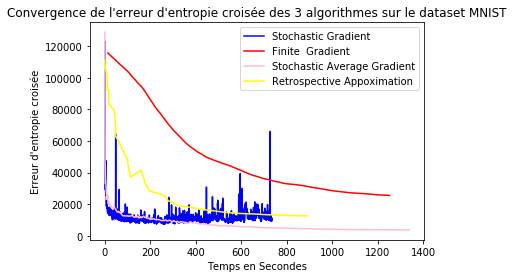

In [377]:
plt.plot(calculatesTimes(trainLogSG["time"]), trainLogSG["train_lossSG"] , color='Blue')
plt.plot(calculatesTimes(trainLogFD["time"]), trainLogFD["train_lossFD"], color ='Red' )
plt.plot(calculatesTimes(trainLogSAG["time"][:800]), trainLogSAG["train_lossFD"][:800] ,color='Pink')
plt.plot(calculatesTimes(trainLogRetro["time"]), trainLogRetro["train_lossFD"] , color='Yellow')

plt.xlabel('Temps en Secondes')
plt.ylabel('Erreur d\'entropie croisée')

plt.legend(["Stochastic Gradient", "Finite  Gradient" , "Stochastic Average Gradient", "Retrospective Appoximation"])
plt.title("Convergence de l'erreur d\'entropie croisée des 3 algorithmes sur le dataset MNIST")
plt.show()

Nous pouvons voir que, au départ, cette technique adaptée du "Retrospective Approximation" converge rapidement vers l'optimum avant de se diriger de manière plutôt constante tel l'algorithme du SAG. L'algorithme du Retrospective Approximation a toutefois une plus  grande erreur que le SAG sur tout le graphique. À quelques reprises, lorsque la taille de l'échantillon augmente, l'algorithme prend un lap de temps considérable à obtenir une solution (qui satisfait le seuil d'erreur voulu) dépendamment des nouvelles données dans l'échantillon de chaque itération. Naturellement, plus l'échantillon est grand, plus le temps d'une itération augmente pour obtenir un niveau de perfomance désiré. Le coût d'itération est donc dépendent des nouvelles données dans l'échantillon analyser. À cause que de nouveaux échantillons moins représentatifs de l'ensemble des données ont quelquesfois augmenté la fonction optimale que nous désirons minimiser, ce pour quoi une technique de "Early-Stopping" serait adéquate s'il n'est pas possible d'exécuter l'algorithme pour une longue période de temps afin d'obtenir l'optimum. 

En bout de ligne, alors que la  taille de l'échantillon grandit, celui-ci devient plus représentatif de l'ensemble et on obtient une meilleure solution pour l'ensemble de fonctions/paires d'entrainement. Lorsque la taille de l'échantillon évalué devient égale (ou similaire) à la taille de l'ensemble des données d'apprentissage, l'algorithme agit un peu comme le Finite Gradient puisqu'il calcule le gradient idéal en prenant en compte le gradient des itérations antérieures. Cependant, à ce point dans l'algorithme, prendre en compte le gradient des itérations antérieures n'est probablement pas avantageux puisque l'échantillon comporte déjà toutes (ou presque) les données de l'ensemble. Les anciens gradients deviennentt donc une information désuète et le gradient calculé durant l'itération présente est probablement une meilleure estimation.

In [380]:
print("SG Temps pour 1000 itérations: ", np.array(trainLogSG["time"]).mean() * 1000 , " secondes")
print("FD Temps pour 1 itération: ", np.array(trainLogFD["time"]).mean(), " secondes")
print("SAG Temps pour 1000 itérations: ", np.array(trainLogSAG["time"][:800]).mean(), " secondes")
print("RetroApprox Temps pour 1 itération: ", np.array(trainLogRetro["time"]).mean(), " secondes")

SG Temps pour 1000 itérations:  0.7366669293014857  secondes
FD Temps pour 1 itération:  15.659318439675554  secondes
SAG Temps pour 1000 itérations:  1.6737234646915748  secondes
RetroApprox Temps pour 1 itération:  12.728815621713874  secondes


Au départ, puisque l'échantillon est très petit, les itérations sont très rapide. Cependant, lorsque l'échantillon est grand, si les nouvelles paires de données de celui-ci sont plus ou moins similaires aux données antérieures, l'algorithme peut prendre un laps de temps considérable. C'est pour cette raison qu'une itération prend (dans notre cas) presque autant de temps qu'une de l'algorithme du Finite Difference.

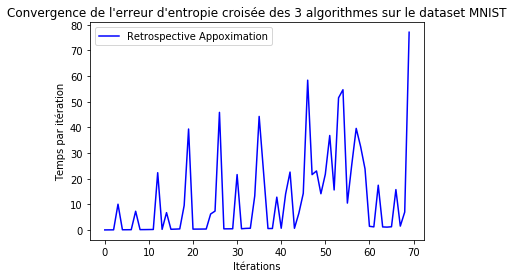

In [378]:
plt.plot(trainLogRetro["time"], color='Blue')

plt.xlabel('Itérations')
plt.ylabel('Temps par itération')

plt.legend(["Retrospective Appoximation"])
plt.title("Convergence de l'erreur d\'entropie croisée des 3 algorithmes sur le dataset MNIST")
plt.show()

Comme nous pouvons voir, certaines itérations prennent un laps de temps minime en comparaison à d'autres lorsque les nouvelles données/fonctions de l'échantillon sont mal représentées par les données antérieures de l'échantillon. 

### Validation

/Users/francoisdavid/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


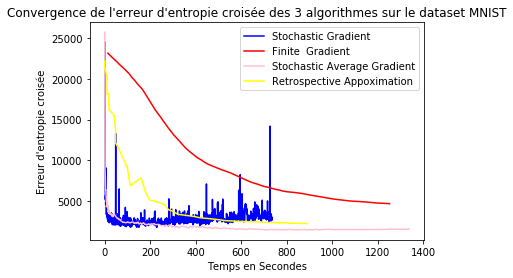

In [381]:
plt.plot(calculatesTimes(trainLogSG["time"]), trainLogSG["validation_lossSG"] , color='Blue')
plt.plot(calculatesTimes(trainLogFD["time"]), trainLogFD["validation_lossFD"], color ='Red' )
plt.plot(calculatesTimes(trainLogSAG["time"][:800]), trainLogSAG["validation_lossFD"][:800] ,color='Pink')
plt.plot(calculatesTimes(trainLogRetro["time"]), trainLogRetro["validation_lossFD"] , color='Yellow')

plt.xlabel('Temps en Secondes')
plt.ylabel('Erreur d\'entropie croisée')

plt.legend(["Stochastic Gradient", "Finite  Gradient" , "Stochastic Average Gradient", "Retrospective Appoximation"])
plt.title("Convergence de l'erreur d\'entropie croisée des 3 algorithmes sur le dataset MNIST")
plt.show()

Nous pouvons voir que l'évaluation de l'algorithme sur l'ensemble de validation démontre les mêmes tendances qu'avec l'ensemble d'entrainement. Donc cela signifie que les tendances sont représentatives des données similaires au MNIST et le modèle peut performer de manière similaire sur de nouvelles images du même type.

Il serait intéressant d'explorer certains ajustements des paramètres pour améliorer la convergence de cet algorithme. Quoiqu'il ne soit pas aussi performant que le SAG, il semble prometteur puisque l'algorithme converge assez rapidement vers le minimum espéré. 